# Libraries

In [2]:
import os
import sys
import glob


import numpy as np
import pandas as pd
import copy as cp

import scipy
import scipy.signal

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import healpy as hp

import pickle
import shutil

import matplotlib.pyplot as plt
import matplotlib        as mpl
from matplotlib.patches import Ellipse
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from pathlib import Path
import more_itertools as mit

import seaborn as sns

In [3]:
# Set the font family for math symbols
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [ ]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
em_spectra_path = hires_data / 'neighbour_emission_spectra'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'

abs_path = mwmc_data_path / 'absorption'
BIGHICAT_data_path = data_path / 'BIGHICAT'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

# Absorption catalog  version 3
print(abs_dr3_data_path)

# Modules

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

script_dir

In [6]:
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf
from mpfit import mpfit

# Fcn

In [12]:
def boostrap_resampling_err(data):
    # Define the number of bootstrap samples
    n_bootstrap_samples = 1000

    resampled_medians = np.empty(n_bootstrap_samples)
    resampled_means = np.empty(n_bootstrap_samples)

    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        resampled_medians[i] = np.median(bootstrap_sample)
        resampled_means[i] = np.mean(bootstrap_sample)
    # endfor

    median_uncertainty = np.std(resampled_medians)
    mean_uncertainty = np.std(resampled_means)

    print("mean_uncertainty: ", mean_uncertainty)
    print("median_uncertainty: ", median_uncertainty)
    return mean_uncertainty, median_uncertainty

In [13]:
# linear model
def linear_fcn(p, x):
    m, b = p
    return m*x + b

# Read BIGHICAT

In [14]:
bighicat_file = BIGHICAT_data_path / 'all_unique_LOS_new.csv'
bighicat_df = pd.read_csv(bighicat_file)
bighicat_nrows, bighicat_ncols = bighicat_df.shape
print(bighicat_nrows, bighicat_ncols)

374 30


In [15]:
bighicat_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,1.658101,914.225482,97.669608,0.025003,0.000991,4.0,0.025335,0.000706,0.078539,0.002189,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,2.995154,144.529741,2.137539,0.622906,0.001829,4.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,2.978961,145.948777,3.302026,0.641714,0.002671,2.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,3.445285,706.217000,92.798770,0.038991,0.002728,3.0,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,4.585191,694.696715,129.059712,0.057092,0.004103,3.0,0.054201,0.002183,0.168024,0.006768,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,3.072800,308.619949,NaN,0.280609,0.008845,1.0,0.041178,0.001210,0.127653,0.003751,0.048668,0.150870,-6.611929,-0.689890,0.163849,18.828846,0.375549,0.055,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,2.079000,495.054726,NaN,0.101940,0.003759,1.0,0.028716,0.000767,0.089020,0.002379,0.024448,0.075789,-4.240314,-0.046202,-1.399806,16.961460,0.294231,0.074,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,2.900700,312.439362,NaN,0.170193,0.005946,2.0,0.044000,0.001390,0.136399,0.004308,0.049554,0.153618,-17.370651,-0.365892,-1.449508,18.306437,0.388935,0.059,NaN,NaN
372,J17422,MACH,81.770200,31.613400,265.597628,54.059010,3.160000,0.060000,0.940000,0.189600,2.970400,682.772331,NaN,0.087578,0.009846,1.0,0.044939,0.001173,0.139312,0.003635,0.046919,0.145447,-13.981676,0.407484,-0.203576,18.122824,0.315143,0.052,NaN,NaN


In [16]:
bighicat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [17]:
bighicat_fcnm = bighicat_df['f_CNM_LOS']
bighicat_av = bighicat_df['AV_2013']

### BIGHICAT high latitudes

In [19]:
blim = 20.
hghlat_df = bighicat_df[abs(bighicat_df.lat) > blim]
hghlat_df.head()

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,1.658101,914.225482,97.669608,0.025003,0.000991,4.0,0.025335,0.000706,0.078539,0.002189,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,2.995154,144.529741,2.137539,0.622906,0.001829,4.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,2.978961,145.948777,3.302026,0.641714,0.002671,2.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,3.445285,706.217000,92.798770,0.038991,0.002728,3.0,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,4.585191,694.696715,129.059712,0.057092,0.004103,3.0,0.054201,0.002183,0.168024,0.006768,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690


In [20]:
hghlat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [21]:
bighicat_tau = hghlat_df.tau_peak.values
bighicat_sigtau = hghlat_df.tau_sensitivity.values

In [22]:
bighicat_hghlat_fcnm = hghlat_df.f_CNM_LOS.values
bighicat_hghlat_nhi = hghlat_df.NHI_LOS.values

In [23]:
print(hghlat_df.survey.value_counts().sum())
print(hghlat_df.survey.value_counts())

224
GMRT04          75
MACH            44
Millennium03    39
21-SPONGE       36
Per14           16
TauGem19        14
Name: survey, dtype: int64


### BIGHICAT components

In [26]:
bighicat_cpn_file = BIGHICAT_data_path / 'all_unique_CNM_det_gaussian_components_new.csv'
bighicat_cpn_df = pd.read_csv(bighicat_cpn_file)
bighicat_cpn_nrows, bighicat_cpn_ncols = bighicat_cpn_df.shape
print(bighicat_cpn_nrows, bighicat_cpn_ncols)

1370 41


In [27]:
bighicat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [28]:
surveys = bighicat_cpn_df.survey.unique().tolist()
surveys

['21-SPONGE',
 'Millennium03',
 'Per14',
 'GMRT04',
 'TauGem19',
 'RiegelCrutcher18',
 'MACH']

In [30]:
bighicat_ts     = bighicat_cpn_df.Ts.values
bighicat_sigts  = bighicat_cpn_df.e_Ts.values
bighicat_tau    = bighicat_cpn_df.tau.values
bighicat_sigtau = bighicat_cpn_df.e_tau.values

bighicat_gb = np.abs(bighicat_cpn_df.lat.values)

# High latitudes

In [35]:
hghlat_cpn_df = bighicat_cpn_df[(abs(bighicat_cpn_df.lat) > blim) & (bighicat_cpn_df.Ts.values < 500.)]
print(hghlat_cpn_df.shape)
hghlat_cpn_df.head()

(413, 41)


,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,Tb,e_Tb,fwhm_em,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,6.904529,0.000000,2.976087,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,25.182555,0.000000,6.006049,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,6.564561,0.890459,2.677941,0.265945,-10.264445,0.346109,0.407920,0.060957,16.656050,2.485132,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,22.468452,0.451441,6.993933,0.040578,-6.669918,0.021774,2.886451,0.099639,162.345752,4.904859,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
7,3C041A,21-SPONGE,131.378783,-29.074651,0.032941,0.000624,8.871778,0.16242071465524413,-1.387832,0.08363020875003654,11.362727,0.000000,9.524291,0.000000,-1.384362,0.000000,1.994321,0.066650,351.823267,7.230769,3.0,5.463896,0.004445,0.092098,0.045187,0.630555,0.024289,3.445285,706.217000,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050


In [ ]:
nsource_hghlat_cpn = 0
hghlat_ncpn = 0
for sv in surveys:
    tmp_df = hghlat_cpn_df[(hghlat_cpn_df.survey.values == sv) & (hghlat_cpn_df.tau.values > 0.)]
    tmp_ts_arr = tmp_df.Ts.values
    tmp_ts_median = np.median(tmp_ts_arr)
    print(sv, ': ncpns', tmp_df.shape, 'ts median: ', tmp_ts_median)
    tmp_nsource = tmp_df.source.unique().shape[0]
    print(tmp_df.source.unique().shape)
    nsource_hghlat_cpn += tmp_nsource
    hghlat_ncpn += tmp_df.shape[0]

    
    print()
print('nsources: ', nsource_hghlat_cpn)
print('n_cpns: ', hghlat_ncpn)

In [37]:
bighicat_taucnm = hghlat_cpn_df.tau.values
bighicat_sigtaucnm = hghlat_cpn_df.e_tau.values

bighicat_tscnm = hghlat_cpn_df.Ts.values
bighicat_sigtscnm = hghlat_cpn_df.e_Ts.values

bighicat_cpn_glon = hghlat_cpn_df.lon.values
bighicat_cpn_glat = hghlat_cpn_df.lat.values

In [38]:
bighicat_cpn_glon[bighicat_cpn_glon < 0.] = bighicat_cpn_glon[bighicat_cpn_glon < 0.] + 360.

In [39]:
bighicat_cpn_widwnm = hghlat_cpn_df.fwhm_em.values
bighicat_cpn_sigwidwnm = hghlat_cpn_df.e_fwhm_em.values

In [43]:
bighicat_nsource_hghlat = len(hghlat_cpn_df.source.unique())
bighicat_nsource_hghlat

163

### Optical depth ($\tau$)

In [44]:
# Optical depth
bighicat_total_ncnm = len(bighicat_taucnm)
print(f"Total CNM components: {bighicat_total_ncnm}")

Total CNM components: 413


In [45]:
stats_series = pd.DataFrame(bighicat_taucnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,413.000000
mean,0.245022
std,0.428383
min,0.002317
25%,0.029000
50%,0.082000
75%,0.286083
max,3.414122


In [46]:
tau_count = int(series_values[0])
tau_mean = round(series_values[1], 2)
tau_std = round(series_values[2], 2)
tau_minval = round(series_values[3], 4)
tau_maxval = round(series_values[-1], 4)
tau_median = round(series_values[5], 2)
tau_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
tau_stats_values = [tau_count, tau_mean, tau_median, tau_std, tau_minval, tau_maxval]

### $T_{spin}$

In [48]:
# Optical depth
bighicat_total_ncnm = len(bighicat_tscnm)
print(f"Total CNM components: {bighicat_total_ncnm}")

Total CNM components: 413


In [49]:
stats_series = pd.DataFrame(bighicat_tscnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,413.000000
mean,113.843154
std,106.127933
min,2.000000
25%,43.620000
50%,72.790000
75%,148.000000
max,478.739454


In [50]:
ts_count = int(series_values[0])
ts_mean = round(series_values[1], 1)
ts_std = round(series_values[2], 1)
ts_minval = round(series_values[3], 1)
ts_maxval = round(series_values[-1], 1)
ts_median = round(series_values[5], 1)
ts_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
ts_stats_values = [ts_count, ts_mean, ts_median, ts_std, ts_minval, ts_maxval]
ts_units = ['', 'K', 'K', 'K', 'K', 'K']

In [52]:
bighicat_tsmin = min(bighicat_tscnm)
bighicat_tsmax = max(bighicat_tscnm)

bighicat_gl_ts  = np.array(bighicat_cpn_glon)
bighicat_gb_ts  = np.array(bighicat_cpn_glat)

bighicat_ind_ts = np.argsort(bighicat_tscnm)
bighicat_ind_ts = bighicat_ind_ts[::-1]
bighicat_tscnm_sorted = bighicat_tscnm[bighicat_ind_ts]
bighicat_gl_ts  = bighicat_gl_ts[bighicat_ind_ts]
bighicat_gb_ts  = bighicat_gb_ts[bighicat_ind_ts]

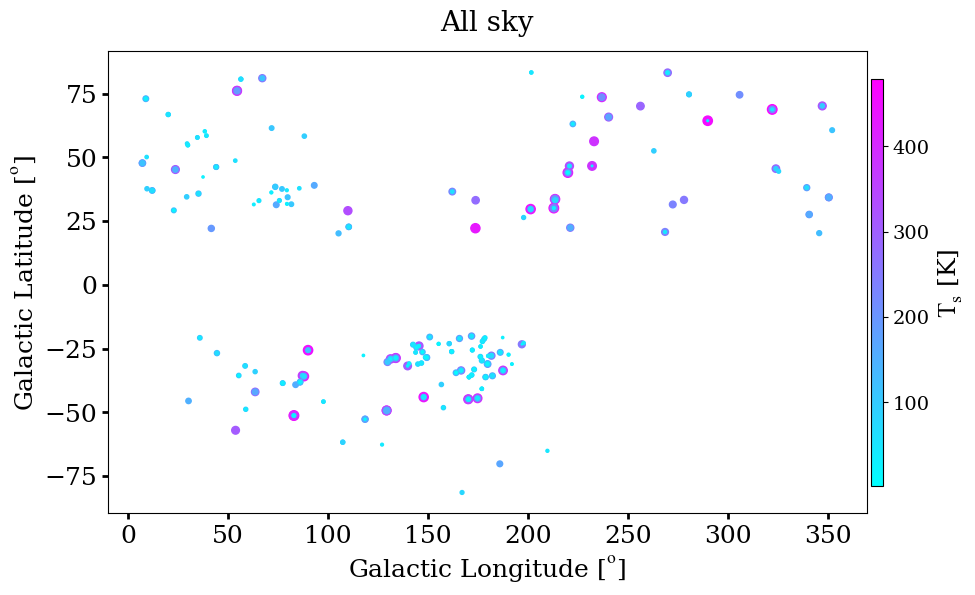

In [53]:
# Plot: Sources with Absorption (LMC foreground)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) # projection=w

cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display the moment map image
sct = ax.scatter(bighicat_gl_ts, bighicat_gb_ts,
                  zorder=0, s=bighicat_tscnm_sorted*0.1,
                  c=bighicat_tscnm_sorted, marker='o', cmap=cm,
                  vmin=bighicat_tsmin, vmax=bighicat_tsmax,
                  label='')


ploti, = plt.plot([], [], '', label=f"Background: GASS HI column density")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=18)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=18)

ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.015, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{T_{s}}$ [K]', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=14)

plt.title(f"All sky", fontsize=20, pad=15)

plt.legend(loc='lower right', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()

# GASKAP: Read table DR3

In [ ]:
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

In [59]:
field_ids = df['sbid'].unique()
print(f'Number of fields: {len(field_ids)}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [60]:
print(f"Types of ratings: {df['rating'].unique()}")

Types of ratings: ['A' 'B' 'C' 'D']


In [61]:
df.groupby(['rating'])['comp_name'].count()

rating
A     294
B    1869
C     343
D     208
Name: comp_name, dtype: int64

In [62]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [64]:
field_ids = df['sbid'].unique()
nfields = len(field_ids)
print(f'Number of fields: {nfields}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [65]:
src_ra = df['ra'].values
src_dec = df['dec'].values

src_gl = df['glon'].values
src_gb = df['glat'].values

src_list = df['comp_name'].values
print(len(src_list))

2714


In [66]:
# df.groupby(["sbid"])["sbid"].count()
fields_series = df['sbid'].value_counts()
fields_series

30665    346
38791    297
33047    290
38845    283
38509    270
38215    268
38466    261
38373    257
38814    242
38758    200
Name: sbid, dtype: int64

In [67]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [69]:
sbid = fields_series.index.to_list()
print(f'Fields: {sbid}')
sbid_counts = fields_series.values
print(f'sbid_counts: {sbid_counts}')

Fields: [30665, 38791, 33047, 38845, 38509, 38215, 38466, 38373, 38814, 38758]
sbid_counts: [346 297 290 283 270 268 261 257 242 200]


Number of sightlines: 2714


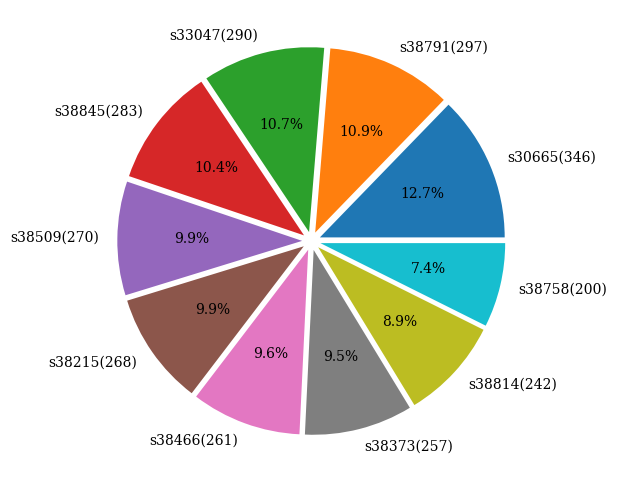

In [70]:
print(f'Number of sightlines: {sbid_counts.sum()}')

plt.figure(figsize=(6,6))
colors = ['g', 'r']
labels = ['s' + str(sbid[i]) + '(' + str(sbid_counts[i]) + ')' for i in range(len(sbid))]
explode = [0.05]*n_fields
plt.pie(df['sbid'].value_counts(normalize=True)*100, colors=None, labels=labels, explode=explode, autopct='%1.1f%%', shadow=False)
plt.title('')
plt.show()

In [71]:
print(f"Types of ratings: {df['rating'].unique()}")

rating_info = df['rating'].value_counts()
rating_types = rating_info.index.to_list()
print(f'Rating types: {rating_types}')

rating_counts = rating_info.values
print(f'Rating counts: {rating_counts}')

n_ratings = len(rating_types)

Types of ratings: ['A' 'B' 'C' 'D']
Rating types: ['B', 'C', 'A', 'D']
Rating counts: [1869  343  294  208]


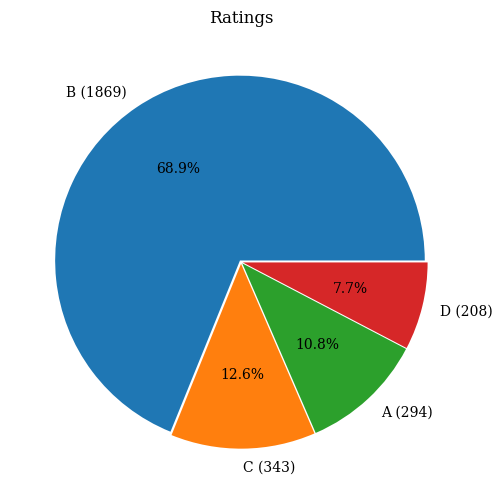

In [72]:
colors = ['g', 'r']
explode = [0.01]*n_ratings
labels = [rating_types[i]+' (' + str(rating_counts[i]) + ')' for i in range(n_ratings)]

plt.figure(figsize=(6,6))
plt.pie(df['rating'].value_counts(normalize=True)*100,
        colors=None,
        labels=labels,
        explode=explode,
        autopct='%1.1f%%',
        shadow=False)

plt.title('Ratings')
plt.show()

# Dectections

In [73]:
det_df = df[df.mw_detection]
print(det_df.shape)
ndet = det_df.shape[0]

det_src_list = det_df.comp_name.values
det_src_gl = det_df.glon.values
det_src_gb = det_df.glat.values

(462, 33)


In [74]:
nsrcs

2714

# Saturated sources

In [75]:
sat_df = df[df.saturated]
sat_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
1462,337,J033454-765712,SB38509_component_225a,53.727799,-76.953516,292.330669,-36.594138,B,18.247999,27.194000,0.000092,0.156399,1.429323,2.623784,1.394428,89.0,-0.034895,5.213831,5.0,3.462193,True,False,6.060,4.850,176.830002,2.441017e+20,False,0.009408,M355-07,38509,38509,False,True
1565,244,J042645-754356,SB38758_component_131a,66.689082,-75.732415,288.902586,-34.845820,C,31.113001,34.987999,0.000157,0.162031,1.613970,2.473195,1.464693,71.0,-0.149277,4.435788,5.0,3.546635,True,False,5.065,4.260,55.369999,2.455275e+20,False,0.011692,M355-02,38758,38758,False,True
1576,287,J040852-721901,SB38758_component_156a,62.220323,-72.317006,286.012697,-37.626103,C,25.906000,32.137001,0.000112,0.213407,1.647171,2.575310,1.460707,58.0,-0.186464,6.679087,5.0,3.755119,True,False,5.330,4.465,65.930000,1.192325e+20,False,0.012949,M355-02,38758,38758,False,True
1603,362,J035607-735425,SB38758_component_210a,59.030638,-73.907151,288.329734,-37.514114,C,19.132999,24.773001,0.000095,0.187999,1.734289,1.665929,1.650538,88.0,-0.083751,0.249388,5.0,3.669418,True,False,5.475,4.540,42.380001,2.405412e+20,False,0.009862,M355-02,38758,38758,False,True
2040,350,J040428-692618,SB38814_component_209a,61.118584,-69.438462,283.100898,-39.422719,C,20.837000,24.475000,0.000103,0.253419,1.949616,1.446376,1.796941,104.0,-0.152676,-2.814305,5.0,3.781250,True,False,5.405,4.100,54.599998,4.971288e+19,False,0.002216,M355+02,38814,38814,False,True
2147,110,J053821-771905,SB38845_component_63a,84.590892,-77.318269,288.944277,-30.404877,C,55.574001,69.519997,0.000205,0.183898,1.653708,1.772035,1.596568,103.0,-0.057140,3.886166,5.0,3.657670,True,False,5.320,4.570,40.900002,1.832042e+20,False,0.014752,M000-02,38845,38845,False,True
2148,111,J053821-771856,SB38845_component_63b,84.588785,-77.315712,288.941479,-30.405840,C,42.478001,54.595001,0.000196,0.174150,1.647953,1.944636,1.559646,94.0,-0.088307,3.884371,5.0,3.603101,True,False,5.410,4.620,44.450001,1.832042e+20,False,0.013924,M000-02,38845,38845,False,True
2234,274,J045859-754650,SB38845_component_171b,74.746789,-75.780713,287.956296,-33.026360,B,16.715000,24.173000,0.000146,0.131266,1.445027,2.826273,1.377659,91.0,-0.067368,4.827469,5.0,3.343459,True,False,5.660,4.970,31.719999,2.820502e+20,False,-0.003037,M000-02,38845,38845,False,True
2324,442,J061332-742400,SB38845_component_289a,93.385278,-74.400240,285.348760,-28.592825,C,15.986000,25.902000,0.000069,0.139208,2.103440,1.627650,1.800502,177.0,-0.302938,2.906457,5.0,3.363643,True,False,6.240,5.050,74.209999,7.335645e+19,True,0.006051,M000-02,38845,38845,False,True
2383,0,J032723-744843,SB38509_component_138a,51.846610,-74.812165,290.789024,-38.410531,C,27.474001,28.622999,0.000132,0.282384,2.663230,1.603476,2.022952,67.0,-0.640278,2.955655,5.0,4.080212,True,False,4.855,4.230,41.660000,0.000000e+00,False,-0.010134,M355-07,"38466,38509,38758",38509,False,True


In [76]:
sat_gl = sat_df.glon.values
sat_gb = sat_df.glat.values

In [77]:
nsat = len(sat_gl)
nsat

12

# GASKAP Tbpeak

In [83]:
outfile1 = LMC_data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
nx1 = 5100
nx2 = 3500

In [85]:
print(outfile1)
tbpeak_data, fg_hdr = fits.getdata(outfile1, header=True)
print(tbpeak_data.shape)
fg_hdr

/Users/kiemhiep/ANU/ASKAP/data/LMC/Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits
(3500, 5100)


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5100                                                  
NAXIS2  =                 3500                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               2550.0 / Pixel coordinate of reference point            
CRPIX2  =               1750.0 / Pixel coordinate of reference point            
CDELT1  =          -0.00666666 / [deg] Coordinate increment at reference point  
CDELT2  =           0.00666666 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'GLON-TAN'        

# Detections

In [87]:
field_det = {
    0 : [30665, 'gaskap_phase2_abs_catalogue_field0_30665_dr3.csv', ['J005337-723143', 'J011056-731406', 'J005611-710706', 'J005238-731244']], # SMC
    1 : [38373, 'gaskap_phase2_abs_catalogue_field1_38373_dr3.csv', ['J044512-654707', 'J044056-662423', 'J050504-641830']],
    2 : [38791, 'gaskap_phase2_abs_catalogue_field2_38791_dr3.csv', ['J054030-631513', 'J053249-634813']],
    3 : [38814, 'gaskap_phase2_abs_catalogue_field3_38814_dr3.csv', ['J035150-695934']],
    4 : [33047, 'gaskap_phase2_abs_catalogue_field4_33047_dr3.csv', ['J060111-703609', 'J053943-693847', 'J051832-693524']],
    5 : [38758, 'gaskap_phase2_abs_catalogue_field5_38758_dr3.csv', ['J040848-750719', 'J044025-762044', 'J040848-750719', 'J043534-745200', 'J035801-760516']],
    6 : [38845, 'gaskap_phase2_abs_catalogue_field6_38845_dr3.csv', ['J045438-751726', 'J052929-724528', 'J045859-754650', 'J054150-733215', 'J054150-733215', 'J061012-743157', 'J045438-751726']],
    7 : [38509, 'gaskap_phase2_abs_catalogue_field7_38509_dr3.csv', ['J031155-765150']],
    8 : [38466, 'gaskap_phase2_abs_catalogue_field8_38466_dr3.csv', ['J025246-710435', 'J025246-710431', 'J025245-710432', 'J025246-710434', 'J031610-682104']],
    9 : [38215, 'gaskap_phase2_abs_catalogue_field9_38215_dr3.csv', ['J012256-751507', 'J010249-795604']]
}

# Summary: Read table of integrated properties

In [113]:
csv_filename   = hires_results / 'hires_result_table_dr3.csv' # DR3
gfit_result_df = pd.read_csv(csv_filename)

ndet_total, ncols = gfit_result_df.shape

print('Number of sightlines with detections: ', ndet_total, '| ncols: ', ncols)
gfit_result_df.head(5)

Number of sightlines with detections:  462 | ncols:  42


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.297762,0.222502,0.222502,0.015980,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.785208,0.561212,0.561212,0.013125,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220


In [114]:
gfit_result_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky'],
      dtype='object')

In [116]:
src_gl = gfit_result_df['glon']
src_gb = gfit_result_df['glat']

gfit_result_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.297762,0.222502,0.222502,0.015980,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.785208,0.561212,0.561212,0.013125,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,J015552-782819,38215,J015552-782819-38215,28.969925,-78.472138,298.888454,-38.145449,1,B,26.514000,0.000090,0.082673,1.017953,1.346728,1.433776,155.0,8.140,5.065,60.930000,0.415822,2.474009,0.877498,0.259883,7.680979e+19,0.038169,0.796402,0.796402,0.056023,1.289206,0.109283,4.298526,0.240953,0.230629,0.022401,1.011325,0.057571,5.587732,0.264577,5.528043,0.174789,1,3.515802
458,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,0.000200,0.182675,1.403734,1.770192,1.506728,75.0,4.165,4.025,70.760002,0.102994,1.552955,2.273083,1.290841,2.978007e+18,6.799796,0.961267,0.961267,0.040064,1.416348,0.171045,4.850994,0.195833,0.222182,0.028215,1.064521,0.051892,6.267342,0.260013,5.887460,0.153349,1,3.515802
459,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,0.001101,0.019195,0.426576,2.945407,1.108120,166.0,4.250,3.990,87.809998,0.681544,6.992312,0.383395,0.027774,0.000000e+00,1.120092,0.602457,0.602457,0.020867,0.572984,0.057847,3.677935,2.271232,0.134567,0.081166,1.020360,0.580898,4.250919,2.271969,4.166914,0.138140,1,3.430639
460,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.706868,6.749742,0.346912,0.060077,0.000000e+00,1.025317,1.018540,1.018540,0.058827,1.827375,0.079087,2.671533,0.199664,0.407645,0.025927,1.061957,0.055842,4.498908,0.214756,4.248404,0.101516,2,3.409348


In [118]:
src_nhi = gfit_result_df.nhi.values
total_src_nhi = src_nhi.sum()
total_src_nhi

2852.85291365021

In [119]:
src_cnm_nhi = gfit_result_df.nhicnm.values
total_src_cnm_nhi = src_cnm_nhi.sum()
print(total_src_cnm_nhi, 'fCNM: ', f'{total_src_cnm_nhi/total_src_nhi:.1%}')

884.967149768293 fCNM:  31.0%


In [120]:
src_wnm_nhi = gfit_result_df.nhiwnm.values
total_src_wnm_nhi = src_wnm_nhi.sum()
print(total_src_wnm_nhi, 'fwNM: ', f'{total_src_wnm_nhi/total_src_nhi:.1%}')

1967.885763881917 fwNM:  69.0%


In [121]:
sources = gfit_result_df['comp_name'].values
nabs_sources = len(sources)
nabs_sources

462

In [122]:
uniq_sources = gfit_result_df['comp_name'].unique()
nabs_uniq_sources = len(uniq_sources)
nabs_uniq_sources

462

# Summary: Read table of CNM components

In [123]:
csv_filename = hires_results / 'hires_result_CNM_components_dr3.csv' # DR3
gfit_cpn_result_df = pd.read_csv(csv_filename)

total_ncnm, ncols = gfit_cpn_result_df.shape

print('Number of CNM components detected: ', total_ncnm, '| ncols: ', ncols)
gfit_cpn_result_df.head(5)

Number of CNM components detected:  691 | ncols:  39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.80,4.215,33.869999,0.094983,0.002162,0.004565,-1.140378,0.027208,2.547627,0.063012,52.597993,4.691695,4.792557,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,0.040406,0.002042,0.005290,0.974041,0.095486,3.642994,0.238888,184.275606,22.602078,7.266817,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,0.014090,0.002040,0.005290,-4.196397,0.240039,3.019618,0.586649,175.371389,68.342573,2.346904,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.23,4.905,175.600006,0.076748,0.002789,0.008792,0.317075,0.097088,5.792015,0.222705,119.640327,21.679161,8.750900,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.23,4.895,175.509995,0.053298,0.002950,0.008432,0.364399,0.115375,4.436012,0.266351,77.722109,9.762152,3.968599,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [124]:
gfit_cpn_result_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'taucnm', 'sigtaucnm',
       'sigtaunoise', 'cencnm', 'sigcencnm', 'widcnm', 'sigwidcnm', 'tscnm',
       'sigtscnm', 'tbcnm', 'sigtbcnm', 'nhicnm_cpn', 'signhicnm_cpn',
       'fcnm_cpn', 'sigfcnm_cpn', 'nhi_tot', 'signhi_tot', 'tsky',
       'nhicnm_avg', 'signhicnm_avg'],
      dtype='object')

In [125]:
print(f'Number of CNM components detected: {total_ncnm}')

Number of CNM components detected: 691


In [126]:
# Read all quantities here
fg_taucnm     = gfit_cpn_result_df['taucnm'].values
fg_sigtaucnm  = gfit_cpn_result_df['sigtaucnm'].values
sig_tau_noise = gfit_cpn_result_df['sigtaunoise'].values

glon = gfit_cpn_result_df['glon'].values
glat = gfit_cpn_result_df['glat'].values

tscnm = gfit_cpn_result_df['tscnm'].values
sigtscnm = gfit_cpn_result_df['sigtscnm'].values
nhicnm_cpn = gfit_cpn_result_df['nhicnm_cpn'].values


fg_widcnm    = gfit_cpn_result_df['widcnm'].values
fg_sigwidcnm = gfit_cpn_result_df['sigwidcnm'].values


# CNM width

In [127]:
print(np.median(fg_widcnm))
print(np.mean(fg_widcnm))

boostrap_resampling_err(fg_widcnm)

2.618015252991518
3.061331196992519
mean_uncertainty:  0.05792677748641644
median_uncertainty:  0.05231582466998528


(0.05792677748641644, 0.05231582466998528)

# HI Spin temperature

In [129]:
weighted_mean = np.sum(tscnm * nhicnm_cpn) / np.sum(nhicnm_cpn)

n_bootstrap = 1000  # Number of bootstrap samples

bootstrap_means = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    indices = np.random.choice(total_ncnm, size=total_ncnm, replace=True)
    bootstrap_values = tscnm[indices]
    bootstrap_weights = nhicnm_cpn[indices]
    bootstrap_mean = np.sum(bootstrap_values * bootstrap_weights) / np.sum(bootstrap_weights)
    bootstrap_means[i] = bootstrap_mean
# Endfor

# Calculate the standard deviation of bootstrap sample means
bootstrap_std = np.std(bootstrap_means)

print('CNM column density Weighted Mean Tspin:', weighted_mean, '[K]')
print('Bootstrap Standard Deviation:', bootstrap_std, '[K]')

CNM column density Weighted Mean Tspin: 65.92504192369789 [K]
Bootstrap Standard Deviation: 2.2018347324017977 [K]


In [130]:
n_bootstrap = 1000  # Number of bootstrap samples

# Calculate the weighted median
def weighted_median(values, weights):
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    cumulative_weights = np.cumsum(sorted_weights)
    median_index = np.searchsorted(cumulative_weights, 0.5 * np.sum(weights))
    weighted_median = sorted_values[median_index]
    return weighted_median

bootstrap_medians = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    indices = np.random.choice(total_ncnm, size=total_ncnm, replace=True)
    bootstrap_values = tscnm[indices]
    bootstrap_weights = nhicnm_cpn[indices]
    bootstrap_median = weighted_median(bootstrap_values, bootstrap_weights)
    bootstrap_medians[i] = bootstrap_median
# Endfor

bootstrap_std = np.std(bootstrap_medians)

print('CNM column density Weighted Median Tspin:', weighted_median(tscnm, nhicnm_cpn), '[K]')
print('Bootstrap Standard Deviation:', bootstrap_std, '[K]')

CNM column density Weighted Median Tspin: 54.47884189512975 [K]
Bootstrap Standard Deviation: 1.6047812940063713 [K]


In [131]:
stats_series = pd.DataFrame(tscnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,60.108511
std,40.618373
min,11.278219
25%,34.908276
50%,49.985345
75%,71.759273
max,307.047625


In [132]:
ts_count = int(series_values[0])
ts_mean = round(series_values[1], 1)
ts_std = round(series_values[2], 1)
ts_minval = round(series_values[3], 1)
ts_maxval = round(series_values[-1], 1)
ts_median = round(series_values[5], 1)
ts_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
ts_stats_values = [ts_count, ts_mean, ts_median, ts_std, ts_minval, ts_maxval]
ts_units = ['', 'K', 'K', 'K', 'K', 'K']

# Spin temperature

In [134]:
tsmin = min(tscnm)
tsmax = max(tscnm)

gl_ts  = np.array(glon)
gb_ts  = np.array(glat)

ind_ts = np.argsort(tscnm)
ind_ts = ind_ts[::-1]
tscnm_sorted = tscnm[ind_ts]
gl_ts  = gl_ts[ind_ts]
gb_ts  = gb_ts[ind_ts]

In [145]:
surveys

['21-SPONGE',
 'Millennium03',
 'Per14',
 'GMRT04',
 'TauGem19',
 'RiegelCrutcher18',
 'MACH']

In [147]:
perseus_datafile = BIGHICAT_data_path / 'SF14_params.csv'
per_cpn_df = pd.read_csv(perseus_datafile)
per_cpn_df['CNM'] = (per_cpn_df.e_Ts > -0.1)
per_cpn_df

,ID,TB,e_TB,VLSR,e_VLSR,DelV,e_DelV,tau,e_tau,Ts,e_Ts,Tkmax,NHI,ForO,CNM
0,3C067,1.88,0.06,-25.8,0.1,4.71,0.18,0.006,-99.000,331.00,-999.00,835,0.17,1.0,False
1,3C067,1.95,0.00,-11.6,0.4,41.30,0.64,0.004,-99.000,438.00,-999.00,2077,1.27,0.0,False
2,3C067,5.34,-9.00,-5.8,0.1,4.81,0.18,0.096,0.002,69.10,8.88,325,0.62,2.0,True
3,3C067,21.02,0.35,-2.3,0.2,9.75,0.17,0.017,-99.000,1254.00,-999.00,861,3.99,0.5,False
4,3C067,23.05,-9.00,-0.3,0.0,2.14,0.04,0.412,0.008,42.88,8.28,607,0.74,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,NV0232+34,2.69,0.03,-6.5,0.1,39.32,0.37,0.011,-99.000,245.00,-999.00,33787,1.68,0.0,False
178,NV0232+34,20.16,-9.00,-1.9,0.1,2.04,0.16,0.130,0.010,43.04,8.28,607,0.22,0.0,True
179,NV0232+34,22.52,-9.00,-0.1,0.2,8.49,0.71,0.058,0.014,321.07,8.88,325,3.10,2.0,True
180,NV0232+34,22.90,-9.00,0.4,0.0,1.82,0.09,0.200,0.012,37.38,14.82,489,0.27,3.0,True


In [148]:
per_cpn_df = per_cpn_df[per_cpn_df.CNM]
per_cpn_df

,ID,TB,e_TB,VLSR,e_VLSR,DelV,e_DelV,tau,e_tau,Ts,e_Ts,Tkmax,NHI,ForO,CNM
2,3C067,5.34,-9.0,-5.8,0.1,4.81,0.18,0.096,0.002,69.10,8.88,325,0.62,2.0,True
4,3C067,23.05,-9.0,-0.3,0.0,2.14,0.04,0.412,0.008,42.88,8.28,607,0.74,0.0,True
5,3C067,17.71,-9.0,1.2,0.1,5.99,0.13,0.186,0.005,89.34,14.82,489,1.94,1.0,True
8,3C068.2,5.09,-9.0,-6.2,0.0,2.58,0.07,0.270,0.000,19.75,8.88,144,0.27,0.0,True
9,3C068.2,-0.09,-9.0,-3.0,0.1,2.63,0.24,0.088,0.004,4.11,8.28,151,0.02,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NV0157+28,13.69,-9.0,-0.5,0.0,1.96,0.12,0.040,0.002,25.80,8.28,607,0.04,0.0,True
178,NV0232+34,20.16,-9.0,-1.9,0.1,2.04,0.16,0.130,0.010,43.04,8.28,607,0.22,0.0,True
179,NV0232+34,22.52,-9.0,-0.1,0.2,8.49,0.71,0.058,0.014,321.07,8.88,325,3.10,2.0,True
180,NV0232+34,22.90,-9.0,0.4,0.0,1.82,0.09,0.200,0.012,37.38,14.82,489,0.27,3.0,True


In [149]:
per_cpn_df.ID.unique().shape

(26,)

In [150]:
mil_datafile = BIGHICAT_data_path / 'nhi_lb_79src_HT03.csv'
mil_df = pd.read_csv(mil_datafile)
mil_df

,ID,source,l,b,nhi,nhi_er,thin,thin_er,cnm,cnm_er,wnm,wnm_er
0,0,3C33,129.4481,-49.3244,2.7800,0.0400,2.8239,0.0680,1.64,0.0232,1.1400,0.0357
1,1,3C18,118.6218,-52.7266,5.9900,0.9500,5.1766,0.0315,5.24,0.9450,0.7500,0.0561
2,2,3C141.0,174.5324,-1.3112,52.6900,1.4800,40.9027,0.5363,23.64,1.2509,29.0500,0.7996
3,3,3C142.1,197.6157,-14.5115,21.9600,2.3000,17.2260,0.7261,8.10,2.2459,13.8600,0.5171
4,4,3C138,187.4052,-11.3437,19.8400,0.9900,17.4826,0.2399,10.69,0.9004,9.1500,0.4088
...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,P0320+05,176.9818,-40.8433,11.2000,0.4800,9.9975,0.7438,5.05,0.3183,6.1500,0.3610
75,75,3C274.1,269.8744,83.1637,2.3600,0.0400,2.2860,0.1201,0.30,0.0193,2.0600,0.0293
76,76,3C207,212.9680,30.1390,5.2500,0.1500,4.9461,0.0969,0.91,0.1267,4.3400,0.0870
77,77,T0629+10,201.5315,0.5079,59.2500,2.8600,45.1748,0.1705,37.02,2.5766,22.2300,1.2404


In [151]:
mil_datafile = BIGHICAT_data_path / 'cpn_params_HT03.csv'
mil_cpn_df = pd.read_csv(mil_datafile)
mil_cpn_df = mil_cpn_df.merge(mil_df[['source', 'l', 'b']], on='source', how='left')
mil_cpn_df['isCNM'] = (mil_cpn_df.Tser > -0.1)
mil_cpn_df = mil_cpn_df[np.abs(mil_cpn_df.b.values) > 9.5]
mil_cpn_df = mil_cpn_df[mil_cpn_df.isCNM]
mil_cpn_df = mil_cpn_df[mil_cpn_df.tau < 4.]
mil_cpn_df = mil_cpn_df[mil_cpn_df.Tspin > 0.]
mil_cpn_df

,Tpeak,Ter,tau,tauer,Vlsr,Ver,delV,dVer,Tspin,Tser,Tkmax,NHI,NHIer,CNM,Frac,Fer,source,l,b,isCNM
1,16.71,-12.0,0.669,0.011,-8.9,0.0,2.43,0.03,34.25,7.89,129.0,1.09,0.2498,1,-18.0,-18.0,3C18,118.6218,-52.7266,True
2,19.80,-12.0,0.077,0.019,-6.7,0.2,8.62,0.70,267.80,5.28,1625.0,3.46,0.8983,0,-18.0,-18.0,3C18,118.6218,-52.7266,True
3,8.09,-12.0,0.181,0.018,-5.7,0.1,3.98,0.25,48.75,9.41,346.0,0.69,0.1540,2,-18.0,-18.0,3C18,118.6218,-52.7266,True
5,10.41,-12.0,0.034,0.001,-4.6,0.1,9.44,0.30,309.63,4.79,1949.0,1.95,0.0886,0,-18.0,-18.0,3C33-1,129.4392,-49.3432,True
7,10.20,-12.0,0.059,0.002,-4.2,0.2,9.31,0.42,177.85,4.54,1892.0,1.90,0.1174,0,-18.0,-18.0,3C33-2,129.4620,-49.2774,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,19.33,-12.0,1.132,0.016,3.2,0.0,3.42,0.04,28.52,19.69,255.0,2.15,1.4793,2,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
339,24.22,-12.0,1.318,0.040,9.2,0.0,3.70,0.05,33.07,18.46,298.0,3.14,1.7494,1,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
340,21.22,-12.0,2.346,0.128,10.6,0.0,1.50,0.05,23.47,9.38,49.0,1.61,0.6485,0,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
352,1.47,-12.0,0.010,0.001,-4.6,0.1,7.94,0.30,149.01,6.39,1379.0,0.23,0.0264,1,-18.0,-18.0,P1055+20,222.5101,63.1302,True


In [153]:
spo_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == surveys[0]]
spo_cpn_df = spo_cpn_df[np.isfinite(spo_cpn_df.Ts.values)]
spo_cpn_df

,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,Tb,e_Tb,fwhm_em,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH
0,1055+018,21-SPONGE,-108.489395,52.773983,0.006418,0.000211,7.061405,0.2533794334354352,-7.276518,0.1093717782616211,6.014311,0.000000,7.043752,0.000000,-6.843069,0.000000,0.827511,0.048499,941.344712,30.798667,1.0,2.943138,0.000000,0.003878,0.018140,0.718834,0.000000,2.115627,2540.335139,0.025512,0.000373,0.079088,0.001155,0.036975,0.114623,16.987488,5.668997,-10.984881,19.149420,0.188328,0.046
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,6.904529,0.000000,2.976087,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,25.182555,0.000000,6.006049,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,6.564561,0.890459,2.677941,0.265945,-10.264445,0.346109,0.407920,0.060957,16.656050,2.485132,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,22.468452,0.451441,6.993933,0.040578,-6.669918,0.021774,2.886451,0.099639,162.345752,4.904859,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,PKS1607,21-SPONGE,44.171276,46.203208,0.013369,0.000371,6.486483,0.3040040241598035,-7.795565,0.21806072040848215,1.444729,0.000000,7.151348,0.000000,-7.795565,0.000000,0.192770,0.021173,114.607548,10.930104,4.0,3.877342,0.229105,0.352060,0.163394,0.770895,0.888318,2.989024,229.487050,0.050723,0.002395,0.157243,0.007426,0.065415,0.202786,-44.153637,-0.355844,0.682174,19.348246,0.637820,0.048
275,PKS2127,21-SPONGE,58.652068,-31.814925,0.107217,0.000993,2.143175,0.020048405232085776,1.526260,0.01140268378850735,5.750364,0.000000,2.036016,0.000000,1.490007,0.000000,0.273887,0.023195,61.449708,5.140834,3.0,4.714311,0.142179,0.161311,0.077554,0.520398,0.670274,2.453320,454.743857,0.064037,0.003025,0.198516,0.009379,0.066924,0.207465,22.407097,0.204960,-0.190081,19.260256,0.634114,0.059
276,PKS2127,21-SPONGE,58.652068,-31.814925,0.072757,0.000702,2.667177,0.038243329322583355,-0.886340,0.02112560248226647,7.618268,0.000000,2.712752,0.000000,-0.885295,0.000000,0.396387,0.016852,105.308706,4.090423,3.0,4.714311,0.142179,0.161311,0.077554,0.520398,0.670274,2.453320,454.743857,0.064037,0.003025,0.198516,0.009379,0.066924,0.207465,22.407097,0.204960,-0.190081,19.260256,0.634114,0.059
277,PKS2127,21-SPONGE,58.652068,-31.814925,0.012796,0.000727,8.329176,0.2107201854834028,1.088381,0.0835187453913894,9.734887,0.000000,8.329176,0.000000,1.199940,0.000000,1.590718,0.133745,769.461638,43.556803,3.0,4.714311,0.142179,0.161311,0.077554,0.520398,0.670274,2.453320,454.743857,0.064037,0.003025,0.198516,0.00937

In [155]:
# SPONGE
spo_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == surveys[0]]
spo_cpn_df = spo_cpn_df[np.isfinite(spo_cpn_df.Ts.values)]
spo_cpn_df = spo_cpn_df[abs(spo_cpn_df.lat) > 9.5]
spo_cpn_df = spo_cpn_df[abs(spo_cpn_df.Ts) < 1000.]
spo_cpn_ts = spo_cpn_df.Ts.values
spo_cpn_sigts = spo_cpn_df.e_Ts.values
spo_ncnm = spo_cpn_sigts.shape[0]
print(surveys[0], 'SPONGE', spo_ncnm, 'CNM components')

# Millennium03
# mil_cpn_df = hghlat_cpn_df[hghlat_cpn_df.survey == surveys[1]]
mil_cpn_ts = mil_cpn_df.Tspin.values
mil_cpn_sigts = mil_cpn_df.Tser.values
mil_ncnm = mil_cpn_ts.shape[0]
print(surveys[1], 'Millennium03', mil_ncnm)

# Per14
# per_cpn_df = hghlat_cpn_df[hghlat_cpn_df.survey == surveys[2]]
per_cpn_ts = per_cpn_df.Ts.values
per_cpn_sigts = per_cpn_df.e_Ts.values
per_ncnm = per_cpn_ts.shape[0]
print(surveys[2], 'Per14', per_ncnm)

# GMRT04
gmr_cpn_df = hghlat_cpn_df[hghlat_cpn_df.survey == surveys[3]]
gmr_cpn_ts = gmr_cpn_df.Ts.values
gmr_cpn_sigts = gmr_cpn_df.e_Ts.values
print('GMRT04', gmr_cpn_ts.shape)

# TauGem19
gno_cpn_df = hghlat_cpn_df[hghlat_cpn_df.survey == surveys[4]]
gno_cpn_ts = gno_cpn_df.Ts.values
gno_cpn_sigts = gno_cpn_df.e_Ts.values
print('TauGem19', gno_cpn_ts.shape)


# MACH
mac_cpn_df = hghlat_cpn_df[hghlat_cpn_df.survey == surveys[6]]
mac_cpn_ts = mac_cpn_df.Ts.values
mac_cpn_sigts = mac_cpn_df.e_Ts.values
print('MACH', mac_cpn_ts.shape)

21-SPONGE SPONGE 138 CNM components
Millennium03 Millennium03 150
Per14 Per14 107
GMRT04 (74,)
TauGem19 (58,)
MACH (19,)


In [156]:
mil_nlos = mil_cpn_df.source.unique().shape[0]
per_nlos = per_cpn_df.ID.unique().shape[0]
spo_nlos = spo_cpn_df.source.unique().shape[0]
print(surveys[1], mil_nlos, 'lines-of-sight')
print(surveys[2], per_nlos)
print(surveys[0], spo_nlos)
print(mil_nlos+per_nlos+spo_nlos, 'lines-of-sight')
# # CNM components
print(mil_ncnm+per_ncnm+spo_ncnm, 'CNM components')


Millennium03 51 lines-of-sight
Per14 26
21-SPONGE 40
117 lines-of-sight
395 CNM components


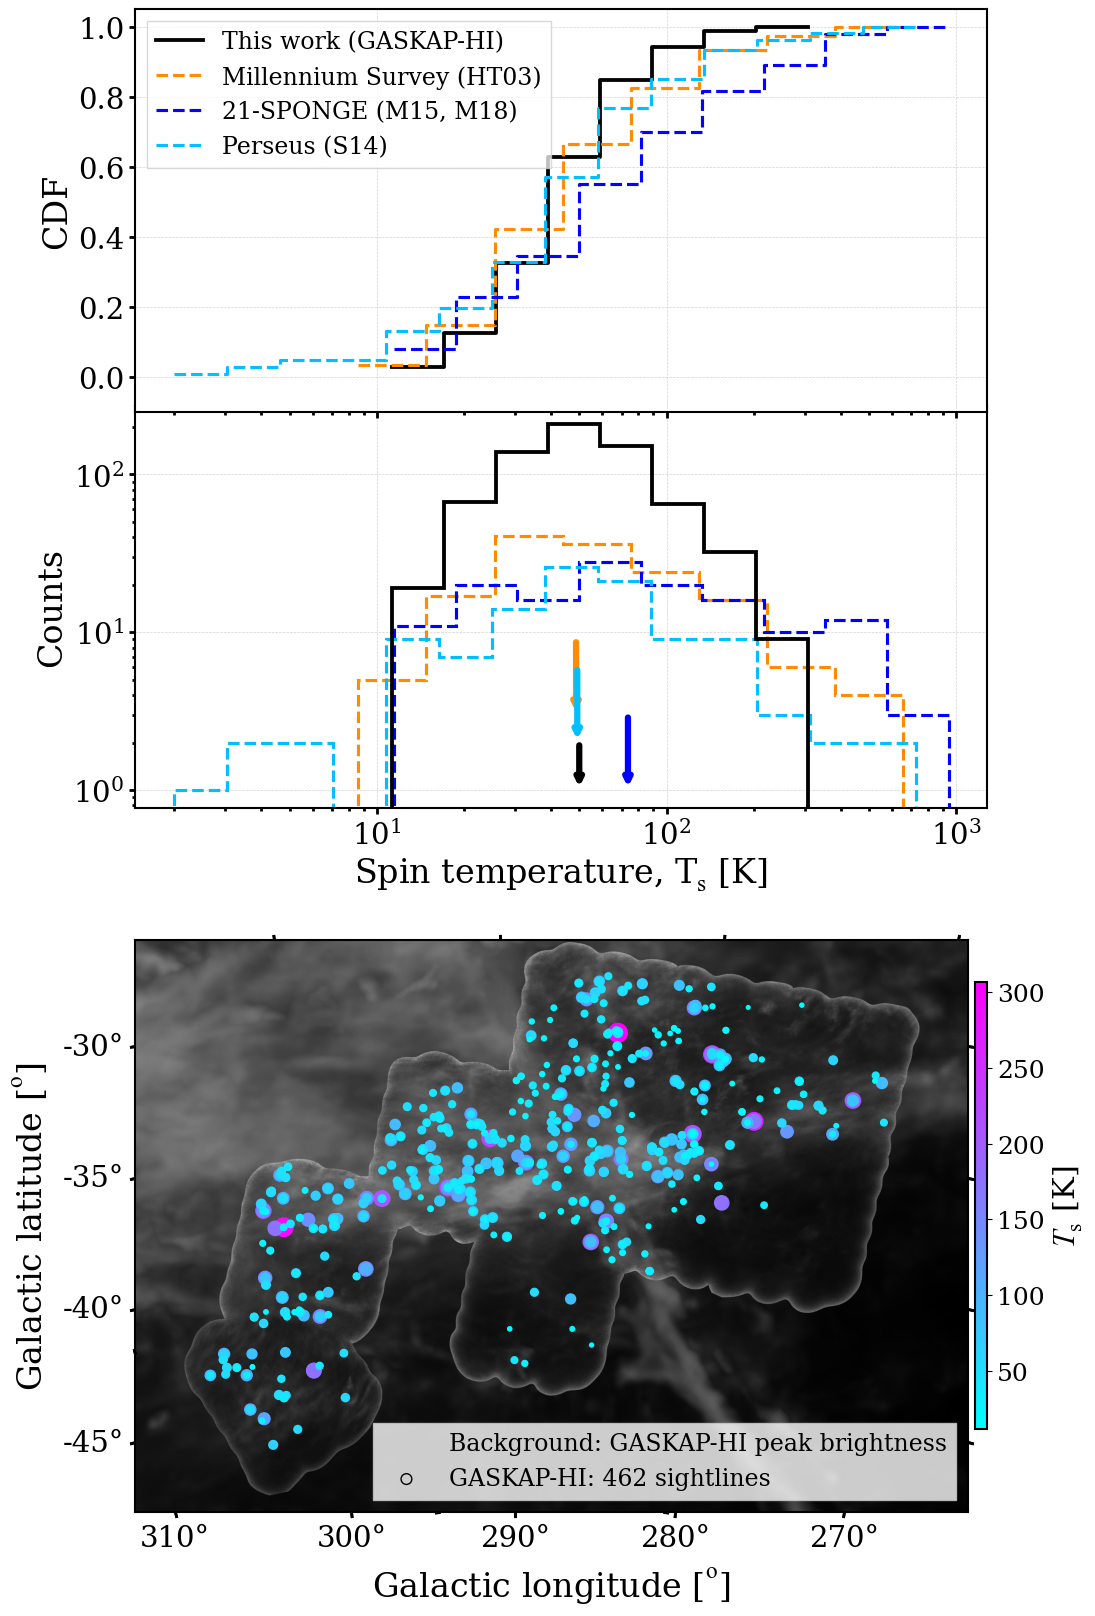

In [160]:
import matplotlib.gridspec as gridspec
mpl.rcParams['axes.linewidth'] = 1.5

fig = plt.figure(figsize=(11,20))
gs = gridspec.GridSpec(11, 10)
ax = plt.subplot(gs[3:6, 0:10])
ax_cdf = plt.subplot(gs[0:3, 0:10],sharex=ax)
ax_map = plt.subplot(gs[6:, 0:10], projection=WCS(fg_hdr))

lw = 2.25
binx = [10, 9, 15, 10, 5, 3]

linesty = '--' 
colors = ['b', 'darkorange', 'deepskyblue', 'gray', 'black', 'skyblue']
survey_labels = ['21-SPONGE (M15, M18)', 'Millennium Survey (HT03)', 'Perseus (S14)', 'GMRT04', 'GNOMES', 'MACH']


xylabel = 24
xytlabel = 21

ploti, = ax.plot([], [], 'k-', lw=lw+0.5, label='This work (GASKAP-HI)')
ploti.set_visible(True)


mil_cnts, mil_bins, _ = ax.hist(mil_cpn_ts, bins = 10**np.linspace(np.log10(np.min(mil_cpn_ts)), np.log10(np.max(mil_cpn_ts)), binx[1]), color=colors[1],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[1], ls=linesty, lw=lw, label=survey_labels[1])
ploti.set_visible(True)

spo_cnts, spo_bins, _ = ax.hist(spo_cpn_ts, bins = 10**np.linspace(np.log10(np.min(spo_cpn_ts)), np.log10(np.max(spo_cpn_ts)), binx[0]), color=colors[0],
         density=False,  histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[0], ls=linesty, lw=lw, label=survey_labels[0])
ploti.set_visible(True)


per_cnts, per_bins, _ = ax.hist(per_cpn_ts, bins = 10**np.linspace(np.log10(np.min(per_cpn_ts)), np.log10(np.max(per_cpn_ts)), binx[2]), color=colors[2],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[2], ls=linesty, lw=lw, label=survey_labels[2])
ploti.set_visible(True)

cnts, bins, _ = ax.hist(tscnm, bins = 10**np.linspace(np.log10(np.min(tscnm)), np.log10(np.max(tscnm)), 9),
         density=False, color='k',
         alpha=1., ls='-', lw=lw+0.5, histtype='step',
         label='')

## Arrows for medians
med_ts = np.median(tscnm)
spo_med_ts = np.median(spo_cpn_ts)
mil_med_ts = np.median(mil_cpn_ts)
per_med_ts = np.median(per_cpn_ts)
ax.annotate('', xy=(med_ts, 1.), xycoords='data', xytext=(med_ts, 2.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='k', lw=4.5, ls='-'))
ax.annotate('', xy=(spo_med_ts, 1.), xycoords='data', xytext=(spo_med_ts, 3.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[0], lw=4.5, ls='-'))
ax.annotate('', xy=(mil_med_ts, 3.), xycoords='data', xytext=(mil_med_ts, 9.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[1], lw=4.5, ls='-'))
ax.annotate('', xy=(per_med_ts, 2.), xycoords='data', xytext=(per_med_ts, 6.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[2], lw=4.5, ls='-'))



# BIGHICAT
ax.set_xlabel(r'Spin temperature, T$_\mathrm{s}$ [K]', fontsize=xylabel)
ax.set_ylabel('Counts', fontsize=xylabel)

ax.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax.tick_params(axis='y', labelsize=xytlabel)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

ax.set_yscale('log')
ax.set_xscale('log')



# Top
cdf = np.cumsum(cnts)/np.sum(cnts)
ax_cdf.set_ylabel('CDF', fontsize=xylabel)

ax_cdf.plot(
    np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2],
    np.vstack((cdf, cdf)).T.flatten(),
    color='k', ls='-', lw=lw+0.5,
    alpha=0.99, label='This work (GASKAP-HI)',
)


cdf3 = np.cumsum(mil_cnts)/np.sum(mil_cnts)

ax_cdf.plot(
    np.vstack((mil_bins, np.roll(mil_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[1], ls=linesty, lw=lw,
    alpha=0.99, label=survey_labels[1]
)


cdf3 = np.cumsum(spo_cnts)/np.sum(spo_cnts)

ax_cdf.plot(
    np.vstack((spo_bins, np.roll(spo_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[0], ls=linesty, lw=lw,
    alpha=0.99, label=survey_labels[0]
)

cdf3 = np.cumsum(per_cnts)/np.sum(per_cnts)
ax_cdf.plot(
    np.vstack((per_bins, np.roll(per_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[2], ls=linesty, lw=lw,
    alpha=0.99, label=survey_labels[2]
)




ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax_cdf.tick_params(axis='y', labelsize=xytlabel)
ax_cdf.tick_params(which='both', width=2)
ax_cdf.tick_params(which='major', length=4)
ax_cdf.tick_params(which='minor', length=2)

ax_cdf.set_ylim(-0.1,1.05)

ax_cdf.tick_params('y', colors='k')
ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
plt.setp(ax_cdf.get_xticklabels(), visible=False)

ax_cdf.legend(loc='upper left', fancybox=False, framealpha=0.75, labelcolor='k', fontsize=17)


# Adjust the position of the second panel
pos2 = ax.get_position()
ax.set_position([pos2.x0, pos2.y0 + 0.015, pos2.width, pos2.height])


# Tspin map
im = ax_map.imshow(tbpeak_data, cmap='gray')

sct = ax_map.scatter(gl_ts, gb_ts,
                  zorder=1, s=tscnm_sorted*0.6,
                  c=tscnm_sorted, marker='o', cmap=cm,
                  vmin=tsmin, vmax=tsmax,
                  transform=ax_map.get_transform('galactic'),
                  label='')


ploti, = plt.plot([], [], '', label=f"Background: GASKAP-HI peak brightness")
ploti.set_visible(False)

ploti = ax_map.scatter([], [], marker='o', s=60, edgecolors='k', facecolors='none', label=f'GASKAP-HI: {ndet} sightlines')
ploti.set_visible(True)


# Add axes labels
ax_map.set_xlabel(r"Galactic longitude [$^\mathrm{o}$]", fontsize=xylabel)
ax_map.set_ylabel(r"Galactic latitude [$^\mathrm{o}$]", fontsize=xylabel)

ax_map.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax_map.tick_params(axis='y', labelsize=xytlabel)
ax_map.tick_params(which='both', width=2)
ax_map.tick_params(which='major', length=4)
ax_map.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(sct, ax=ax_map, orientation='vertical', fraction=0.015, pad=0.0075, aspect=35)
cbar.ax.set_ylabel(r'$T_\mathrm{s}$ [K]', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=18)

ax_map.legend(loc='lower right', fancybox=False, framealpha=0.80, labelcolor='k', fontsize=17)

# Adjust the position of the second panel
pos2 = ax_map.get_position()
ax_map.set_position([pos2.x0, pos2.y0 - 0.01, pos2.width, pos2.height])

plt.show()

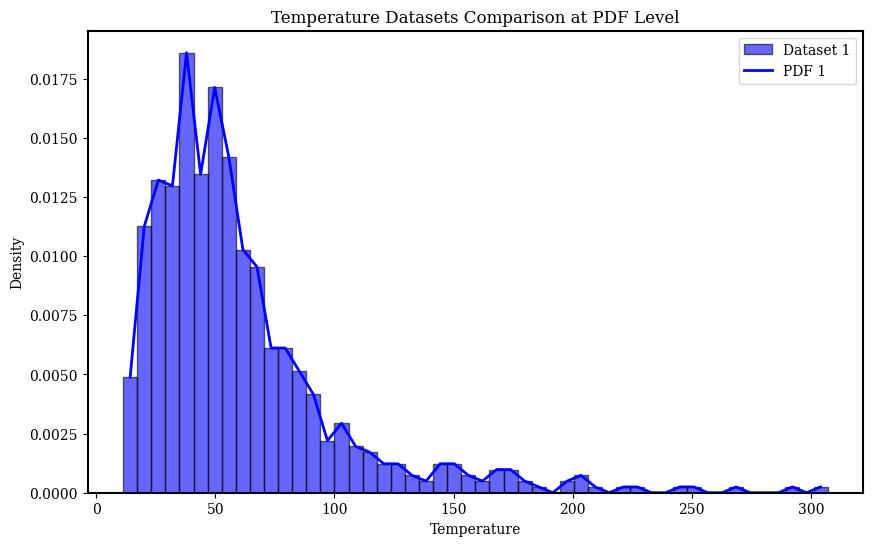

In [164]:
# Calculate histograms and PDF
bins = 50

hist1, bin_edges1 = np.histogram(tscnm, bins=bins, density=True)
# hist2, bin_edges2 = np.histogram(data2, bins=bins, density=True)
# hist3, bin_edges3 = np.histogram(data3, bins=bins, density=True)

bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2
bin_centers3 = (bin_edges3[:-1] + bin_edges3[1:]) / 2

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(tscnm, bins=bins, density=True, alpha=0.6, label='Dataset 1', color='blue', edgecolor='black')
# plt.hist(data2, bins=bins, density=True, alpha=0.6, label='Dataset 2', color='green', edgecolor='black')
# plt.hist(data3, bins=bins, density=True, alpha=0.6, label='Dataset 3', color='red', edgecolor='black')

# Plot PDFs
plt.plot(bin_centers1, hist1, label='PDF 1', color='blue', linewidth=2)
# plt.plot(bin_centers2, hist2, label='PDF 2', color='green', linewidth=2)
# plt.plot(bin_centers3, hist3, label='PDF 3', color='red', linewidth=2)

# Add labels and legend
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.title('Temperature Datasets Comparison at PDF Level')
plt.legend()

# Show the plot
plt.show()


In [165]:
print(np.median(tscnm))
print(np.mean(tscnm))

boostrap_resampling_err(tscnm)

49.98534530752544
60.108511071658405
mean_uncertainty:  1.5204295696389745
median_uncertainty:  1.1306537125543332


(1.5204295696389745, 1.1306537125543332)

In [168]:
# Just selecting CNM < 250 K
per_cpn_ts_cnm = per_cpn_ts[np.where(per_cpn_ts < 200)[0]]
print(np.median(per_cpn_ts_cnm), boostrap_resampling_err(per_cpn_ts_cnm))

mean_uncertainty:  4.188638297269306
median_uncertainty:  3.325829329280142
47.92 (4.188638297269306, 3.325829329280142)


In [169]:
# Just selecting CNM < 250 K
mil_cpn_ts_cnm = mil_cpn_ts[np.where(mil_cpn_ts < 200)[0]]
print(np.median(mil_cpn_ts_cnm), boostrap_resampling_err(mil_cpn_ts_cnm))

mean_uncertainty:  3.7537075250067446
median_uncertainty:  3.282904585134938
45.23 (3.7537075250067446, 3.282904585134938)


In [170]:
# Just selecting CNM < 250 K
spo_cpn_ts_cnm = spo_cpn_ts[np.where(spo_cpn_ts < 200)[0]]
print(np.median(spo_cpn_ts_cnm), boostrap_resampling_err(spo_cpn_ts_cnm))

mean_uncertainty:  4.657423223771764
median_uncertainty:  5.3064747063974105
60.47435045701597 (4.657423223771764, 5.3064747063974105)


In [171]:
# Just selecting CNM < 250 K
tscnm_cnm = tscnm[np.where(tscnm < 200)[0]]
print(np.median(tscnm_cnm), boostrap_resampling_err(tscnm_cnm))

mean_uncertainty:  1.3133068655239932
median_uncertainty:  1.1502416019382802
49.6262381300516 (1.3133068655239932, 1.1502416019382802)


In [172]:
print(per_cpn_ts.max(), np.median(per_cpn_ts), boostrap_resampling_err(per_cpn_ts))
print(mil_cpn_ts.max(), np.median(mil_cpn_ts), boostrap_resampling_err(mil_cpn_ts))
print(spo_cpn_ts.max(), np.median(spo_cpn_ts), boostrap_resampling_err(spo_cpn_ts))

mean_uncertainty:  9.571818703956406
median_uncertainty:  3.8051511364333477
725.42 49.2 (9.571818703956406, 3.8051511364333477)
mean_uncertainty:  8.7226596153755
median_uncertainty:  4.3861940538210344
656.14 48.72 (8.7226596153755, 4.3861940538210344)
mean_uncertainty:  13.288443030856078
median_uncertainty:  8.374321515443267
941.3447118143986 73.6085775971961 (13.288443030856078, 8.374321515443267)


In [173]:
print(mil_cpn_ts_cnm.max(), np.median(mil_cpn_ts_cnm), boostrap_resampling_err(mil_cpn_ts_cnm))
print(per_cpn_ts_cnm.max(), np.median(per_cpn_ts_cnm), boostrap_resampling_err(per_cpn_ts_cnm))
print(spo_cpn_ts_cnm.max(), np.median(spo_cpn_ts_cnm), boostrap_resampling_err(spo_cpn_ts_cnm))

mean_uncertainty:  3.6246636558485106
median_uncertainty:  3.076569332942133
180.36 45.23 (3.6246636558485106, 3.076569332942133)
mean_uncertainty:  4.169568389347367
median_uncertainty:  3.1224199494902987
194.98 47.92 (4.169568389347367, 3.1224199494902987)
mean_uncertainty:  4.1297377191472115
median_uncertainty:  4.713862950665747
196.42824175978907 60.47435045701597 (4.1297377191472115, 4.713862950665747)


In [174]:
gno_cpn_ts = bighicat_cpn_df[bighicat_cpn_df.survey == 'TauGem19'].Ts
gno_cpn_ts_250 = bighicat_cpn_df[(bighicat_cpn_df.survey == 'TauGem19') & (bighicat_cpn_df.Ts < 250.)].Ts
print(gno_cpn_ts.median())
print(gno_cpn_ts_250.median())


print(gno_cpn_ts.max(), np.median(gno_cpn_ts), boostrap_resampling_err(gno_cpn_ts))
print(gno_cpn_ts_250.max(), np.median(gno_cpn_ts_250), boostrap_resampling_err(gno_cpn_ts_250))

print(spo_cpn_ts.max(), np.median(spo_cpn_ts), boostrap_resampling_err(spo_cpn_ts))


53.62213567070173
53.60824331472985
mean_uncertainty:  2.382905192542283
median_uncertainty:  2.1780871840144247
323.27545654226054 53.62213567070173 (2.382905192542283, 2.1780871840144247)
mean_uncertainty:  2.197867638378523
median_uncertainty:  2.1499532071248355
230.8144604696368 53.60824331472985 (2.197867638378523, 2.1499532071248355)
mean_uncertainty:  14.45625240492442
median_uncertainty:  8.54263865467206
941.3447118143986 73.6085775971961 (14.45625240492442, 8.54263865467206)


# Opacity sensitivity vs Tspin

In [176]:
tmp = pd.merge(gfit_cpn_result_df, gfit_result_df, how='left', on=['comp_name'])
tmp.shape

(691, 80)

In [177]:
tmp.head()

,comp_name,sbid_x,uniq_name_x,ra_x,dec_x,glon_x,glat_x,in_bridge_x,rating_x,flux_peak_x,mean_cont_x,sd_cont_x,opacity_range_x,max_s_max_n_x,max_noise_x,num_chan_noise_x,semi_maj_axis_x,semi_min_axis_x,pa_x,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky_x,nhicnm_avg,signhicnm_avg,sbid_y,uniq_name_y,ra_y,dec_y,glon_y,glat_y,in_bridge_y,rating_y,flux_peak_y,mean_cont_y,sd_cont_y,opacity_range_y,max_s_max_n_y,max_noise_y,num_chan_noise_y,semi_maj_axis_y,semi_min_axis_y,pa_y,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky_y
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.80,4.215,33.869999,0.094983,0.002162,0.004565,-1.140378,0.027208,2.547627,0.063012,52.597993,4.691695,4.792557,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.80,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,0.040406,0.002042,0.005290,0.974041,0.095486,3.642994,0.238888,184.275606,22.602078,7.266817,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,0.014090,0.002040,0.005290,-4.196397,0.240039,3.019618,0.586649,175.371389,68.342573,2.346904,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.23,4.905,175.600006,0.076748,0.002789,0.008792,0.317075,0.097088,5.792015,0.222705,119.640327,21.679161,8.750900,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.23,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.23,4.895,175.509995,0.053298,0.002950,0.008432,0.364399,0.115375,4.436012,0.266351,77.722109,9.762152,3.968599,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.35

In [178]:
taucnm = tmp.taucnm.values
sigtaucnm = tmp.sigtaucnm.values
tscnm = tmp.tscnm.values
sigtscnm = tmp.sigtscnm

In [179]:
tau_sensitivity = tmp.sigtaunoise.values
tscnm_sensitivity = tmp.tscnm.values

In [180]:
# Sort the arrays based on the values in 'values'
sorted_indices = np.argsort(tau_sensitivity)
sorted_tau_sensitivity = tau_sensitivity[sorted_indices]
sorted_tscnm_sensitivity = tscnm_sensitivity[sorted_indices]

In [182]:
n = len(sorted_tau_sensitivity)
segment_length = n // 3

tau_sensitivity_segments = [sorted_tau_sensitivity[i:i+segment_length] for i in range(0, n, segment_length)]
tscnm_segments = [sorted_tscnm_sensitivity[i:i+segment_length] for i in range(0, n, segment_length)]

In [184]:
print(tau_sensitivity_segments[0].min(), tau_sensitivity_segments[0].max())
print(tau_sensitivity_segments[1].min(), tau_sensitivity_segments[1].max())
print(tau_sensitivity_segments[2].min(), tau_sensitivity_segments[2].max())

0.0019152315513153 0.0275888848319461
0.0275888848319461 0.0584101367754028
0.0584101367754028 0.2546686487960626


In [186]:
def boostrap_resampling_err(data):
    n_bootstrap_samples = 1000

    resampled_medians = np.empty(n_bootstrap_samples)
    resampled_means = np.empty(n_bootstrap_samples)

    # Perform bootstrap resampling
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        resampled_medians[i] = np.median(bootstrap_sample)
        resampled_means[i] = np.mean(bootstrap_sample)
    # Endfor

    median_uncertainty = np.std(resampled_medians)
    mean_uncertainty = np.std(resampled_means)
    return mean_uncertainty, median_uncertainty

In [187]:
# Medians of Tspin in different segments of tau_sensitivity
for segi in tscnm_segments:
    print(np.median(segi), '+/- (mean_err, median_err)', boostrap_resampling_err(segi))

65.73908617198074 +/- (mean_err, median_err) (3.4474208576894494, 3.324115697284941)
52.227542043448565 +/- (mean_err, median_err) (1.824881790233718, 2.1399300338920617)
38.849518542220586 +/- (mean_err, median_err) (1.2693679831633866, 1.1213662708991323)
29.89679940371194 +/- (mean_err, median_err) (1.0658141036401503e-14, 1.0658141036401503e-14)


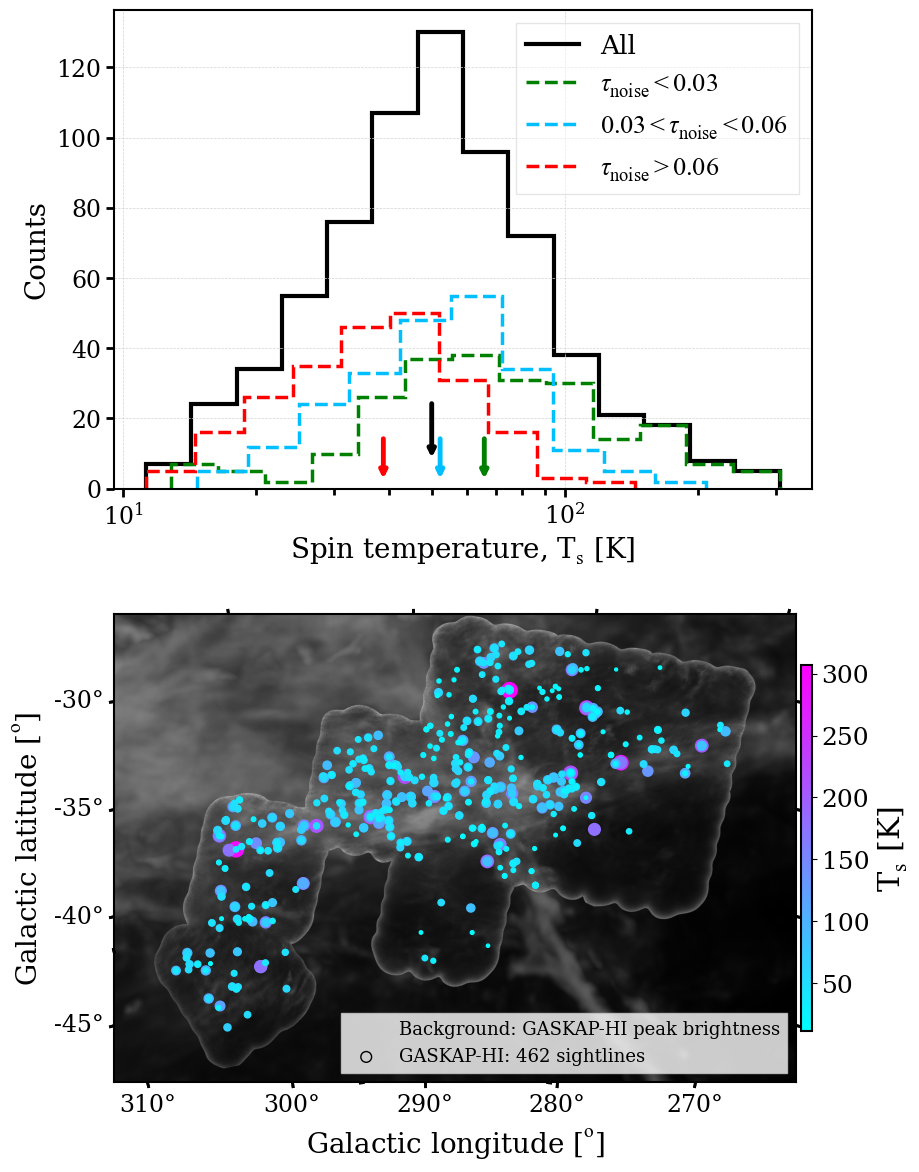

In [247]:
import matplotlib.gridspec as gridspec
mpl.rcParams['axes.linewidth'] = 1.5

fig = plt.figure(figsize=(9,14.))
gs = gridspec.GridSpec(9, 10)
ax = plt.subplot(gs[0:4, 0:10])
ax_map = plt.subplot(gs[5:, 0:10], projection=WCS(fg_hdr)) # projection=WCS(fg_hdr))

lw = 2.5
binx = [14, 11, 11]

linesty = '--' 
colors = ['green', 'deepskyblue', 'r']

xylabel = 20
xytlabel = 17


ploti, = ax.plot([], [], 'k-', lw=lw+0.5, label='All')
ploti.set_visible(True)





mil_cnts, mil_bins, _ = ax.hist(tscnm_segments[0], bins = 10**np.linspace(np.log10(np.min(tscnm_segments[0])), np.log10(np.max(tscnm_segments[0])), binx[0]), color=colors[0],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[0], ls=linesty, lw=lw, label=r'$\tau_\mathrm{noise} < 0.03$')
ploti.set_visible(True)

spo_cnts, spo_bins, _ = ax.hist(tscnm_segments[1], bins = 10**np.linspace(np.log10(np.min(tscnm_segments[1])), np.log10(np.max(tscnm_segments[1])), binx[1]), color=colors[1],
         density=False,  histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[1], ls=linesty, lw=lw, label=r'$0.03 < \tau_\mathrm{noise} < 0.06$')
ploti.set_visible(True)


per_cnts, per_bins, _ = ax.hist(tscnm_segments[2], bins = 10**np.linspace(np.log10(np.min(tscnm_segments[2])), np.log10(np.max(tscnm_segments[2])), binx[2]), color=colors[2],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[2], ls=linesty, lw=lw, label=r'$\tau_\mathrm{noise} > 0.06$')
ploti.set_visible(True)



cnts, bins, _ = ax.hist(tscnm, bins = 10**np.linspace(np.log10(np.min(tscnm)), np.log10(np.max(tscnm)), 15),
         density=False, color='k', zorder=-10,
         alpha=1., ls='-', lw=lw+0.5, histtype='step',
         label='')

## Arrows for medians
med_ts = np.median(tscnm)
spo_med_ts = np.median(tscnm_segments[0])
mil_med_ts = np.median(tscnm_segments[1])
per_med_ts = np.median(tscnm_segments[2])
y1 = 2.
y2 = 15.
ax.annotate('', xy=(med_ts, 8.), xycoords='data', xytext=(med_ts, 25.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='k', lw=3.5, ls='-'))
ax.annotate('', xy=(spo_med_ts, y1), xycoords='data', xytext=(spo_med_ts, y2), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[0], lw=3.5, ls='-'))
ax.annotate('', xy=(mil_med_ts, y1), xycoords='data', xytext=(mil_med_ts, y2), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[1], lw=3.5, ls='-'))
ax.annotate('', xy=(per_med_ts, y1), xycoords='data', xytext=(per_med_ts, y2), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[2], lw=3.5, ls='-'))


# ax.set_title(f'Spin temperature')
ax.set_xlabel(r'Spin temperature, T$_\mathrm{s}$ [K]', fontsize=xylabel)
ax.set_ylabel('Counts', fontsize=xylabel)

ax.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax.tick_params(axis='y', labelsize=xytlabel)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='upper right', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=19)

ax.set_xscale('log')




# Tspin map
im = ax_map.imshow(tbpeak_data, cmap='gray')

sct = ax_map.scatter(gl_ts, gb_ts,
                  zorder=1, s=tscnm_sorted*0.4,
                  c=tscnm_sorted, marker='o', cmap=cm,
                  vmin=tsmin, vmax=tsmax,
                  transform=ax_map.get_transform('galactic'),
                  label='')


ploti, = plt.plot([], [], '', label=f"Background: GASKAP-HI peak brightness")
ploti.set_visible(False)

ploti = ax_map.scatter([], [], marker='o', s=60, edgecolors='k', facecolors='none', label=f'GASKAP-HI: {ndet} sightlines')
ploti.set_visible(True)


# Add axes labels
ax_map.set_xlabel(r"Galactic longitude [$^\mathrm{o}$]", fontsize=xylabel)
ax_map.set_ylabel(r"Galactic latitude [$^\mathrm{o}$]", fontsize=xylabel)

ax_map.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax_map.tick_params(axis='y', labelsize=xytlabel)
ax_map.tick_params(which='both', width=2)
ax_map.tick_params(which='major', length=4)
ax_map.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(sct, ax=ax_map, orientation='vertical', fraction=0.015, pad=0.0075, aspect=35)
cbar.ax.set_ylabel(r'T$_\mathrm{s}$ [K]', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=18)

ax_map.legend(loc='lower right', fancybox=False, framealpha=0.80, labelcolor='k', fontsize=13)

# Adjust the position of the second panel
pos2 = ax_map.get_position()
ax_map.set_position([pos2.x0, pos2.y0 - 0.01, pos2.width, pos2.height])


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.0001
                    )

plt.show()

In [190]:
print(np.median(tscnm_segments[0]))
print(np.median(tscnm_segments[1]))
print(np.median(tscnm_segments[2]))

65.73908617198074
52.227542043448565
38.849518542220586


In [191]:
print(tau_sensitivity_segments[0].min(), tau_sensitivity_segments[0].max())
print(tau_sensitivity_segments[1].min(), tau_sensitivity_segments[1].max())
print(tau_sensitivity_segments[2].min(), tau_sensitivity_segments[2].max())

0.0019152315513153 0.0275888848319461
0.0275888848319461 0.0584101367754028
0.0584101367754028 0.2546686487960626


# WNM Width, Td

In [326]:
csv_wnm_filename = hires_results / 'hires_result_WNM_components_dr3.csv'
wnm_gfit_df = pd.read_csv(csv_wnm_filename)
wnm_gfit_df

,comp_name,sbid,ra,dec,glon,glat,widwnm,sigwidwnm,tdwnm,sigtdwnm,nhicpn_wnm,signhicpn_wnm
0,J005611-710706,30665,14.047482,-71.118446,302.378462,-46.004698,15.816736,0.548476,5468.697141,379.275487,1.839400,0.080748
1,J011049-731427,30665,17.707468,-73.240921,300.996592,-43.814386,24.376619,2.202789,12989.639708,2347.613533,2.090209,0.275080
2,J004048-714600,30665,10.200474,-71.766489,304.115161,-45.337319,14.763123,1.851916,4764.382609,1195.307694,1.943385,0.808341
3,J005732-741242,30665,14.385728,-74.211897,302.365011,-42.909634,19.802166,0.762153,8571.869347,659.834758,2.377233,0.134253
4,J004741-753010,30665,11.920932,-75.502942,303.246204,-41.623018,7.121130,2.301708,1108.531310,716.603966,2.237264,0.454828
...,...,...,...,...,...,...,...,...,...,...,...,...
565,J014454-801334,38215,26.225640,-80.226328,300.129741,-36.609263,8.251607,0.208319,1488.425937,75.153267,4.850994,0.195833
566,J012808-751251,38215,22.036673,-75.214201,299.807394,-41.690592,10.357730,2.318988,2345.197140,1050.130666,1.776493,1.684430
567,J012808-751251,38215,22.036673,-75.214201,299.807394,-41.690592,24.274771,10.272706,12881.322571,10902.351484,1.901442,1.523546
568,J010238-762315,38215,15.659985,-76.387702,302.062577,-40.721635,19.267161,1.005726,8114.945385,847.183603,2.671533,0.199664


In [342]:
wnm_gfit_df['is_unm'] = wnm_gfit_df.tdwnm < 4000.
wnm_gfit_df

,comp_name,sbid,ra,dec,glon,glat,widwnm,sigwidwnm,tdwnm,sigtdwnm,nhicpn_wnm,signhicpn_wnm,is_unm
0,J005611-710706,30665,14.047482,-71.118446,302.378462,-46.004698,15.816736,0.548476,5468.697141,379.275487,1.839400,0.080748,False
1,J011049-731427,30665,17.707468,-73.240921,300.996592,-43.814386,24.376619,2.202789,12989.639708,2347.613533,2.090209,0.275080,False
2,J004048-714600,30665,10.200474,-71.766489,304.115161,-45.337319,14.763123,1.851916,4764.382609,1195.307694,1.943385,0.808341,False
3,J005732-741242,30665,14.385728,-74.211897,302.365011,-42.909634,19.802166,0.762153,8571.869347,659.834758,2.377233,0.134253,False
4,J004741-753010,30665,11.920932,-75.502942,303.246204,-41.623018,7.121130,2.301708,1108.531310,716.603966,2.237264,0.454828,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,J014454-801334,38215,26.225640,-80.226328,300.129741,-36.609263,8.251607,0.208319,1488.425937,75.153267,4.850994,0.195833,True
566,J012808-751251,38215,22.036673,-75.214201,299.807394,-41.690592,10.357730,2.318988,2345.197140,1050.130666,1.776493,1.684430,True
567,J012808-751251,38215,22.036673,-75.214201,299.807394,-41.690592,24.274771,10.272706,12881.322571,10902.351484,1.901442,1.523546,False
568,J010238-762315,38215,15.659985,-76.387702,302.062577,-40.721635,19.267161,1.005726,8114.945385,847.183603,2.671533,0.199664,False


In [343]:
wnm_gfit_df['nhicpn_unm'] = np.where(wnm_gfit_df.is_unm, wnm_gfit_df.nhicpn_wnm, 0.)
wnm_gfit_df

,comp_name,sbid,ra,dec,glon,glat,widwnm,sigwidwnm,tdwnm,sigtdwnm,nhicpn_wnm,signhicpn_wnm,is_unm,nhicpn_unm
0,J005611-710706,30665,14.047482,-71.118446,302.378462,-46.004698,15.816736,0.548476,5468.697141,379.275487,1.839400,0.080748,False,0.000000
1,J011049-731427,30665,17.707468,-73.240921,300.996592,-43.814386,24.376619,2.202789,12989.639708,2347.613533,2.090209,0.275080,False,0.000000
2,J004048-714600,30665,10.200474,-71.766489,304.115161,-45.337319,14.763123,1.851916,4764.382609,1195.307694,1.943385,0.808341,False,0.000000
3,J005732-741242,30665,14.385728,-74.211897,302.365011,-42.909634,19.802166,0.762153,8571.869347,659.834758,2.377233,0.134253,False,0.000000
4,J004741-753010,30665,11.920932,-75.502942,303.246204,-41.623018,7.121130,2.301708,1108.531310,716.603966,2.237264,0.454828,True,2.237264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,J014454-801334,38215,26.225640,-80.226328,300.129741,-36.609263,8.251607,0.208319,1488.425937,75.153267,4.850994,0.195833,True,4.850994
566,J012808-751251,38215,22.036673,-75.214201,299.807394,-41.690592,10.357730,2.318988,2345.197140,1050.130666,1.776493,1.684430,True,1.776493
567,J012808-751251,38215,22.036673,-75.214201,299.807394,-41.690592,24.274771,10.272706,12881.322571,10902.351484,1.901442,1.523546,False,0.000000
568,J010238-762315,38215,15.659985,-76.387702,302.062577,-40.721635,19.267161,1.005726,8114.945385,847.183603,2.671533,0.199664,False,0.000000


In [344]:
wnm_gfit_df['signhicpn_unm'] = np.where(wnm_gfit_df.is_unm, wnm_gfit_df.signhicpn_wnm, 0.)
wnm_gfit_df

,comp_name,sbid,ra,dec,glon,glat,widwnm,sigwidwnm,tdwnm,sigtdwnm,nhicpn_wnm,signhicpn_wnm,is_unm,nhicpn_unm,signhicpn_unm
0,J005611-710706,30665,14.047482,-71.118446,302.378462,-46.004698,15.816736,0.548476,5468.697141,379.275487,1.839400,0.080748,False,0.000000,0.000000
1,J011049-731427,30665,17.707468,-73.240921,300.996592,-43.814386,24.376619,2.202789,12989.639708,2347.613533,2.090209,0.275080,False,0.000000,0.000000
2,J004048-714600,30665,10.200474,-71.766489,304.115161,-45.337319,14.763123,1.851916,4764.382609,1195.307694,1.943385,0.808341,False,0.000000,0.000000
3,J005732-741242,30665,14.385728,-74.211897,302.365011,-42.909634,19.802166,0.762153,8571.869347,659.834758,2.377233,0.134253,False,0.000000,0.000000
4,J004741-753010,30665,11.920932,-75.502942,303.246204,-41.623018,7.121130,2.301708,1108.531310,716.603966,2.237264,0.454828,True,2.237264,0.454828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,J014454-801334,38215,26.225640,-80.226328,300.129741,-36.609263,8.251607,0.208319,1488.425937,75.153267,4.850994,0.195833,True,4.850994,0.195833
566,J012808-751251,38215,22.036673,-75.214201,299.807394,-41.690592,10.357730,2.318988,2345.197140,1050.130666,1.776493,1.684430,True,1.776493,1.684430
567,J012808-751251,38215,22.036673,-75.214201,299.807394,-41.690592,24.274771,10.272706,12881.322571,10902.351484,1.901442,1.523546,False,0.000000,0.000000
568,J010238-762315,38215,15.659985,-76.387702,302.062577,-40.721635,19.267161,1.005726,8114.945385,847.183603,2.671533,0.199664,False,0.000000,0.000000


In [ ]:
def bootstrap(data, errors, num_samples=10000):
    """Perform bootstrapping on the given data with associated errors."""
    n = len(data)
    means = np.empty(num_samples)
    medians = np.empty(num_samples)
    
    for i in range(num_samples):
        # Create a sample by resampling with replacement and adding error
        indices = np.random.choice(n, size=n, replace=True)
        sample = data[indices] + np.random.normal(0, 10.*errors[indices])
        means[i] = np.mean(sample)
        medians[i] = np.median(sample)
    
    return means, medians

# Example data
# Calculate mean and median of original data
mean = np.mean(a)
median = np.median(a)

# Perform bootstrapping
num_bootstrap_samples = 10000
means, medians = bootstrap(a, b, num_samples=num_bootstrap_samples)

# Calculate uncertainties
mean_uncertainty = np.std(means)
median_uncertainty = np.std(medians)

print(f"Mean: {mean:.2f} ± {mean_uncertainty:.2f}")
print(f"Median: {median:.2f} ± {median_uncertainty:.2f}")


Mean: 0.29 ± 0.01
Median: 0.28 ± 0.01


In [327]:
td = wnm_gfit_df.tdwnm.values
print(np.min(td), np.median(td), np.max(td))

269.64021916231724 4588.328965498858 21916.401481019984


In [328]:
fg_widwnm = wnm_gfit_df.widwnm.values
fg_sigwidwnm = wnm_gfit_df.sigwidwnm.values
td = wnm_gfit_df.tdwnm.values
sigtd = wnm_gfit_df.sigtdwnm.values

nhiwnm_cpn = wnm_gfit_df.nhicpn_wnm.values
signhiwnm_cpn = wnm_gfit_df.signhicpn_wnm.values

wnm_glon = wnm_gfit_df.glon.values
wnm_glat = wnm_gfit_df.glat.values

In [346]:
gas_wnm_los_df = wnm_gfit_df.groupby('comp_name')['nhicpn_wnm'].sum()
gas_wnm_los_df_srcs = gas_wnm_los_df.index.values
gas_wnm_los_df_nhiwnm = gas_wnm_los_df.values
gas_wnm_los_df

comp_name
J001424-733911    1.760664
J002144-741500    2.348561
J002223-742825    1.898151
J002248-734007    1.999738
J002335-735529    2.215657
                    ...   
J061014-743208    5.903621
J061014-743214    5.988199
J061024-711917    5.087182
J061030-700235    4.304630
J061328-741046    5.550406
Name: nhicpn_wnm, Length: 462, dtype: float64

In [347]:
gas_wnm_los_df_signhiwnm = wnm_gfit_df.groupby('comp_name')['signhicpn_wnm'].apply(lambda x: np.sqrt((x**2).sum())).values
gas_wnm_los_df_signhiwnm.shape

(462,)

In [348]:
gas_unm_los_df = wnm_gfit_df.groupby('comp_name')['nhicpn_unm'].sum()
gas_unm_los_df_srcs = gas_unm_los_df.index.values
gas_unm_los_df_nhiunm = gas_unm_los_df.values
gas_unm_los_df

comp_name
J001424-733911    0.000000
J002144-741500    0.000000
J002223-742825    0.000000
J002248-734007    1.999738
J002335-735529    2.215657
                    ...   
J061014-743208    0.000000
J061014-743214    0.000000
J061024-711917    0.000000
J061030-700235    0.000000
J061328-741046    0.000000
Name: nhicpn_unm, Length: 462, dtype: float64

In [357]:
gfit_result_df = pd.merge(gfit_result_df, gas_unm_los_df, on='comp_name')
gfit_result_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,nhicpn_unm
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176,0.000000
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591,0.000000
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467,0.000000
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.297762,0.222502,0.222502,0.015980,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386,0.000000
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.785208,0.561212,0.561212,0.013125,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220,2.237264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,J015552-782819,38215,J015552-782819-38215,28.969925,-78.472138,298.888454,-38.145449,1,B,26.514000,0.000090,0.082673,1.017953,1.346728,1.433776,155.0,8.140,5.065,60.930000,0.415822,2.474009,0.877498,0.259883,7.680979e+19,0.038169,0.796402,0.796402,0.056023,1.289206,0.109283,4.298526,0.240953,0.230629,0.022401,1.011325,0.057571,5.587732,0.264577,5.528043,0.174789,1,3.515802,4.298526
458,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,0.000200,0.182675,1.403734,1.770192,1.506728,75.0,4.165,4.025,70.760002,0.102994,1.552955,2.273083,1.290841,2.978007e+18,6.799796,0.961267,0.961267,0.040064,1.416348,0.171045,4.850994,0.195833,0.222182,0.028215,1.064521,0.051892,6.267342,0.260013,5.887460,0.153349,1,3.515802,4.850994
459,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,0.001101,0.019195,0.426576,2.945407,1.108120,166.0,4.250,3.990,87.809998,0.681544,6.992312,0.383395,0.027774,0.000000e+00,1.120092,0.602457,0.602457,0.020867,0.572984,0.057847,3.677935,2.271232,0.134567,0.081166,1.020360,0.580898,4.250919,2.271969,4.166914,0.138140,1,3.430639,1.776493
460,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.706868,6.749742,0.346912,0.060077,0.000000e+00,1.025317,1.018540,1.018540,0.058827,1.827375,0.079087,2.671533,0.199664,0.407645,0.025927,1.061957,0.055842,4.498908,0.

In [361]:
gas_unm_los_df = wnm_gfit_df.groupby('comp_name')['signhicpn_unm'].apply(lambda x: np.sqrt((x**2).sum()))
gas_unm_los_df_signhiwnm = gas_unm_los_df.values
gas_unm_los_df_signhiwnm.shape
gas_unm_los_df

comp_name
J001424-733911    0.000000
J002144-741500    0.000000
J002223-742825    0.000000
J002248-734007    0.176677
J002335-735529    0.221813
                    ...   
J061014-743208    0.000000
J061014-743214    0.000000
J061024-711917    0.000000
J061030-700235    0.000000
J061328-741046    0.000000
Name: signhicpn_unm, Length: 462, dtype: float64

In [362]:
gfit_result_df = pd.merge(gfit_result_df, gas_unm_los_df, on='comp_name')
gfit_result_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,nhicpn_unm,signhicpn_unm
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176,0.000000,0.000000
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591,0.000000,0.000000
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467,0.000000,0.000000
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.297762,0.222502,0.222502,0.015980,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386,0.000000,0.000000
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.785208,0.561212,0.561212,0.013125,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220,2.237264,0.454828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,J015552-782819,38215,J015552-782819-38215,28.969925,-78.472138,298.888454,-38.145449,1,B,26.514000,0.000090,0.082673,1.017953,1.346728,1.433776,155.0,8.140,5.065,60.930000,0.415822,2.474009,0.877498,0.259883,7.680979e+19,0.038169,0.796402,0.796402,0.056023,1.289206,0.109283,4.298526,0.240953,0.230629,0.022401,1.011325,0.057571,5.587732,0.264577,5.528043,0.174789,1,3.515802,4.298526,0.240953
458,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,0.000200,0.182675,1.403734,1.770192,1.506728,75.0,4.165,4.025,70.760002,0.102994,1.552955,2.273083,1.290841,2.978007e+18,6.799796,0.961267,0.961267,0.040064,1.416348,0.171045,4.850994,0.195833,0.222182,0.028215,1.064521,0.051892,6.267342,0.260013,5.887460,0.153349,1,3.515802,4.850994,0.195833
459,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,0.001101,0.019195,0.426576,2.945407,1.108120,166.0,4.250,3.990,87.809998,0.681544,6.992312,0.383395,0.027774,0.000000e+00,1.120092,0.602457,0.602457,0.020867,0.572984,0.057847,3.677935,2.271232,0.134567,0.081166,1.020360,0.580898,4.250919,2.271969,4.166914,0.138140,1,3.430639,1.776493,1.684430
460,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.706868,6.749742,0.346912,0.060077,0.000000e+00,1.025317,1.018540,1.018540,0.

In [365]:
gfit_result_df['funm'] = gfit_result_df.nhicpn_unm.values/gfit_result_df.nhi.values
gfit_result_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,nhicpn_unm,signhicpn_unm,funm
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176,0.000000,0.000000,0.000000
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591,0.000000,0.000000,0.000000
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467,0.000000,0.000000,0.000000
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.297762,0.222502,0.222502,0.015980,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386,0.000000,0.000000,0.000000
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.785208,0.561212,0.561212,0.013125,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220,2.237264,0.454828,0.611522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,J015552-782819,38215,J015552-782819-38215,28.969925,-78.472138,298.888454,-38.145449,1,B,26.514000,0.000090,0.082673,1.017953,1.346728,1.433776,155.0,8.140,5.065,60.930000,0.415822,2.474009,0.877498,0.259883,7.680979e+19,0.038169,0.796402,0.796402,0.056023,1.289206,0.109283,4.298526,0.240953,0.230629,0.022401,1.011325,0.057571,5.587732,0.264577,5.528043,0.174789,1,3.515802,4.298526,0.240953,0.769279
458,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,0.000200,0.182675,1.403734,1.770192,1.506728,75.0,4.165,4.025,70.760002,0.102994,1.552955,2.273083,1.290841,2.978007e+18,6.799796,0.961267,0.961267,0.040064,1.416348,0.171045,4.850994,0.195833,0.222182,0.028215,1.064521,0.051892,6.267342,0.260013,5.887460,0.153349,1,3.515802,4.850994,0.195833,0.774011
459,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,0.001101,0.019195,0.426576,2.945407,1.108120,166.0,4.250,3.990,87.809998,0.681544,6.992312,0.383395,0.027774,0.000000e+00,1.120092,0.602457,0.602457,0.020867,0.572984,0.057847,3.677935,2.271232,0.134567,0.081166,1.020360,0.580898,4.250919,2.271969,4.166914,0.138140,1,3.430639,1.776493,1.684430,0.417908
460,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.2799

In [383]:
gfit_result_df['sigfunm'] = fitlibs.uncertainty_of_ratio(gfit_result_df.nhicpn_unm.values, 
                                                         gfit_result_df.nhi.values,
                                                         gfit_result_df.signhicpn_unm.values,
                                                         gfit_result_df.signhi.values)
gfit_result_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,nhicpn_unm,signhicpn_unm,funm,sigfunm
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176,0.000000,0.000000,0.000000,0.000000
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591,0.000000,0.000000,0.000000,0.000000
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467,0.000000,0.000000,0.000000,0.000000
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.297762,0.222502,0.222502,0.015980,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386,0.000000,0.000000,0.000000,0.000000
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.785208,0.561212,0.561212,0.013125,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220,2.237264,0.454828,0.611522,0.157382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,J015552-782819,38215,J015552-782819-38215,28.969925,-78.472138,298.888454,-38.145449,1,B,26.514000,0.000090,0.082673,1.017953,1.346728,1.433776,155.0,8.140,5.065,60.930000,0.415822,2.474009,0.877498,0.259883,7.680979e+19,0.038169,0.796402,0.796402,0.056023,1.289206,0.109283,4.298526,0.240953,0.230629,0.022401,1.011325,0.057571,5.587732,0.264577,5.528043,0.174789,1,3.515802,4.298526,0.240953,0.769279,0.056447
458,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,0.000200,0.182675,1.403734,1.770192,1.506728,75.0,4.165,4.025,70.760002,0.102994,1.552955,2.273083,1.290841,2.978007e+18,6.799796,0.961267,0.961267,0.040064,1.416348,0.171045,4.850994,0.195833,0.222182,0.028215,1.064521,0.051892,6.267342,0.260013,5.887460,0.153349,1,3.515802,4.850994,0.195833,0.774011,0.044805
459,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,0.001101,0.019195,0.426576,2.945407,1.108120,166.0,4.250,3.990,87.809998,0.681544,6.992312,0.383395,0.027774,0.000000e+00,1.120092,0.602457,0.602457,0.020867,0.572984,0.057847,3.677935,2.271232,0.134567,0.081166,1.020360,0.580898,4.250919,2.271969,4.166914,0.138140,1,3.430639,1.776493,1.684430,0.417908,0.454866
460,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,

In [390]:
gfit_result_unm_df = gfit_result_df[gfit_result_df.funm >= 0.]

In [391]:
funm_los = gfit_result_unm_df.funm.values
sigfunm_los = gfit_result_unm_df.sigfunm.values
print(np.min(funm_los), np.median(funm_los), np.mean(funm_los), np.max(funm_los))

0.0 0.0 0.26474298205968605 0.9007532123855415


In [392]:
np.where(funm_los == 0.)[0].shape

(233,)

In [395]:
def bootstrap(data, errors, num_samples=10000):
    """Perform bootstrapping on the given data with associated errors."""
    n = len(data)
    means = np.empty(num_samples)
    medians = np.empty(num_samples)
    
    for i in range(num_samples):
        # Create a sample by resampling with replacement and adding error
        indices = np.random.choice(n, size=n, replace=True)
        sample = data[indices] + np.random.normal(0, 10.*errors[indices])
        means[i] = np.mean(sample)
        medians[i] = np.median(sample)
    
    return means, medians

# Example data
# Calculate mean and median of original data
mean = np.mean(funm_los)
median = np.median(funm_los)

# Perform bootstrapping
num_bootstrap_samples = 10000
means, medians = bootstrap(funm_los, sigfunm_los, num_samples=num_bootstrap_samples)

# Calculate uncertainties
mean_uncertainty = np.std(means)
median_uncertainty = np.std(medians)

print(f"Mean: {mean:.2f} ± {mean_uncertainty:.2f}")
print(f"Median: {median:.2f} ± {median_uncertainty:.2f}")


Mean: 0.26 ± 0.05
Median: 0.00 ± 0.00


In [352]:
np.sum(gas_unm_los_df_nhiunm)

754.9068162380347

In [367]:
np.sum(gfit_result_df.nhicpn_unm)

754.9068162380346

In [337]:
nhiwnm_sum = np.sum(nhiwnm_cpn)
print('nhiwnm_sum: ', nhiwnm_sum)

nhiwnm_sum:  1892.2721031664491


In [338]:
nwnm = len(td)
unm_idx = np.where(td < 4000.)[0]
numn = len(unm_idx)
print('NWNM, NUNM:', nwnm, nunm)
print(100.*nunm / 570)

NWNM, NUNM: 570 242
42.45614035087719


In [336]:
nhiunm_cpn = nhiwnm_cpn[unm_idx]
signhiunm_cpn = signhiwnm_cpn[unm_idx]
nhiunm_sum = np.sum(nhiunm_cpn)
print('nhiunm_sum:', nhiunm_sum)
print('nhiunm_sum/nhiwnm_sum:', 100.*nhiunm_sum/nhiwnm_sum)
print('nhiunm_sum/nhitot:', 100.*nhiunm_sum/(835+1892.3))

nhiunm_sum: 754.9068162380347
nhiunm_sum/nhiwnm_sum: 39.89419993957556
nhiunm_sum/nhitot: 27.67963979899661


In [286]:
print(np.median(fg_widwnm))
print(np.mean(fg_widwnm))

boostrap_resampling_err(fg_widwnm)

14.502659803469388
14.198932048218726


(0.19933132918120267, 0.26134284510128475)

In [287]:
finite_fg_sigwidwnm = fg_sigwidwnm[fg_sigwidwnm != 0.]
fg_sigwidwnm[fg_sigwidwnm == 0.] = np.min(finite_fg_sigwidwnm)

In [288]:
np.sqrt(np.sum(finite_fg_sigwidwnm**2)) / len(finite_fg_sigwidwnm)

0.12396196093425728

In [289]:
stats_series = pd.DataFrame(fg_widwnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,569.000000
mean,14.198932
std,4.794534
min,3.977408
25%,10.583880
50%,14.502660
75%,17.552810
max,31.663546


In [290]:
widwnm_count = int(series_values[0])
widwnm_mean = round(series_values[1], 1)
widwnm_std = round(series_values[2], 1)
widwnm_minval = round(series_values[3], 1)
widwnm_maxval = round(series_values[-1], 1)
widwnm_median = round(series_values[5], 1)
widwnm_labels = ['CNM components', 'Mean', 'Median', 'Std', 'Min', 'Max']
widwnm_stats_values = [widwnm_count, widwnm_mean, widwnm_median, widwnm_std, widwnm_minval, widwnm_maxval]
widwnm_units = ['', 'km s$^{-1}$', 'km s$^{-1}$', 'km s$^{-1}$', 'km s$^{-1}$', 'km s$^{-1}$']

In [292]:
widwnmmin = min(fg_widwnm)
widwnmmax = max(fg_widwnm)

In [295]:
total_nwnm = len(td)
print('total_nwnm', total_nwnm)
lowtd_idx = np.where(td < 500.)[0]
nlowtd = len(lowtd_idx)
print('N low Td < 500 K: ', nlowtd, 'total number of WNM component', total_nwnm, f'{nlowtd/total_nwnm:.1%}')
lowtd_nhiwnm = nhiwnm_cpn[lowtd_idx]
print('low td NHI:', np.sum(lowtd_nhiwnm), 'total WNM NHI all sources: ', total_src_wnm_nhi, f'{lowtd_nhiwnm.sum()/total_src_wnm_nhi:.1%}')
print('low td NHI:', np.sum(lowtd_nhiwnm), 'total NHI all sources: ', total_src_nhi, f'{lowtd_nhiwnm.sum()/total_src_nhi:.1%}')

unmtd_idx = np.where((td < 5000.) & (td > 500.))[0]
nunmtd = len(unmtd_idx)
print('N UNM: ', nunmtd, 'total number of WNM component', total_nwnm, f'{nunmtd/total_nwnm:.1%}')
unmtd_nhiwnm = nhiwnm_cpn[unmtd_idx]
print('low td NHI:', np.sum(unmtd_nhiwnm), 'total WNM NHI all sources: ', total_src_wnm_nhi, f'{unmtd_nhiwnm.sum()/total_src_wnm_nhi:.1%}')
print('low td NHI:', np.sum(unmtd_nhiwnm), 'total NHI all sources: ', total_src_nhi, f'{unmtd_nhiwnm.sum()/total_src_nhi:.1%}')

total_nwnm 569
N low Td < 500 K:  8 total number of WNM component 569 1.4%
low td NHI: 9.312418518025458 total WNM NHI all sources:  1967.885763881917 0.5%
low td NHI: 9.312418518025458 total NHI all sources:  2852.85291365021 0.3%
N UNM:  307 total number of WNM component 569 54.0%
low td NHI: 1011.5006616819744 total WNM NHI all sources:  1967.885763881917 51.4%
low td NHI: 1011.5006616819744 total NHI all sources:  2852.85291365021 35.5%


# Doppler temperature: $T_d$

In [296]:
print(np.median(td))
print(np.mean(td))

boostrap_resampling_err(td)

4597.751310461145
4908.812199790581


(134.33895350499412, 166.85553280914127)

In [297]:
mean_td_std, median_td_std = boostrap_resampling_err(td)
print(mean_td_std, median_td_std)

128.1988149385645 161.0865910781516


In [298]:
stats_series = pd.DataFrame(td).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,569.000000
mean,4908.812200
std,3094.907483
min,345.820228
25%,2448.724662
50%,4597.751310
75%,6735.090702
max,21916.401481


In [299]:
td_count = int(series_values[0])
td_mean = round(series_values[1], 1)
td_std = round(series_values[2], 1)
td_minval = round(series_values[3], 1)
td_maxval = round(series_values[-1], 1)
td_median = round(series_values[5], 1)
td_labels = ['WNM components', 'Mean', 'Median', 'Std', 'Min', 'Max']
td_stats_values = [td_count, td_mean, td_median, td_std, td_minval, td_maxval]
td_units = ['', 'K', 'K', 'K', 'K', 'K']

In [301]:
tdmin = min(td)
tdmax = max(td)
gl_td  = np.array(wnm_glon)
gb_td  = np.array(wnm_glat)
ind_td = np.argsort(td)
ind_td = ind_td[::-1]
td_sorted = td[ind_td]
gl_td  = gl_td[ind_td]
gb_td  = gb_td[ind_td]

# Td from BIGHICAT

In [304]:
# SPONGE Td
spo_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == surveys[0]]
spo_cpn_df = spo_cpn_df[np.isfinite(spo_cpn_df.fwhm_em.values) & (spo_cpn_df.fwhm_em.values > 4.) ]
spo_cpn_td = 21.86*spo_cpn_df.fwhm_em.values**2
spo_cpn_sigtd = 2.*21.86*spo_cpn_td*spo_cpn_df.e_fwhm_em.values

spo_nwnm = spo_cpn_td.shape[0]
print(surveys[0], '21SPONGE', spo_nwnm, 'WNM components')

21-SPONGE 21SPONGE 79 WNM components


In [305]:
# Per14 Td
perseus_datafile = BIGHICAT_data_path / 'SF14_params.csv'
per_cpn_df = pd.read_csv(perseus_datafile)
per_cpn_df['CNM'] = (per_cpn_df.e_Ts > -0.1)
per_wnm_cpn_df = per_cpn_df[~per_cpn_df.CNM] # WNM components only

per_cpn_td = 21.86*per_wnm_cpn_df.DelV.values**2
per_cpn_sigtd = 2.*21.86*per_cpn_td*per_wnm_cpn_df.e_DelV.values

per_idx = np.where(per_cpn_td > 300.)[0]
per_cpn_td = per_cpn_td[per_idx]
per_cpn_sigtd = per_cpn_sigtd[per_idx]

per_nwnm = per_cpn_td.shape[0]
print(surveys[2], 'Per14', per_nwnm, 'WNM components')

Per14 Per14 73 WNM components


In [306]:
# Millennium03 Td
mil_datafile = BIGHICAT_data_path / 'cpn_params_HT03.csv'
mil_cpn_df = pd.read_csv(mil_datafile)
mil_cpn_df = mil_cpn_df.merge(mil_df[['source', 'l', 'b']], on='source', how='left')
mil_cpn_df['isCNM'] = (mil_cpn_df.Tser > -0.1)
mil_cpn_df = mil_cpn_df[np.abs(mil_cpn_df.b.values) > 9.5]
mil_wnm_cpn_df = mil_cpn_df[~mil_cpn_df.isCNM]


mil_cpn_td = 21.86*mil_wnm_cpn_df.delV.values**2
mil_cpn_sigtd = 2.*21.86*mil_cpn_td*mil_wnm_cpn_df.dVer.values

mil_idx = np.where(mil_cpn_td > 300.)[0]
mil_cpn_td = mil_cpn_td[mil_idx]
mil_cpn_sigtd = mil_cpn_sigtd[mil_idx]

mil_nwnm = mil_cpn_td.shape[0]
print(surveys[1], 'Millennium03', mil_nwnm, 'WNM components')

Millennium03 Millennium03 138 WNM components


In [307]:
hghlat_cpn_df.survey.unique()

array(['21-SPONGE', 'Millennium03', 'Per14', 'GMRT04', 'TauGem19', 'MACH'],
      dtype=object)

In [308]:
print(np.min(td), np.mean(td), np.median(td), np.max(td))

345.8202276633117 4908.812199790581 4597.751310461145 21916.401481019984


GASKAP:  345.8202276633117 4908.812199790581 4908.812199790581 21916.401481019984
SPO:  357.88971809841905 1855.4785698318374 1016.3024743603773 24843.499498953493
MIL:  302.507424 15955.310732101449 5690.994145000001 315256.35306600004
PER:  434.830376 18278.84032967123 4333.666303999999 119737.714986


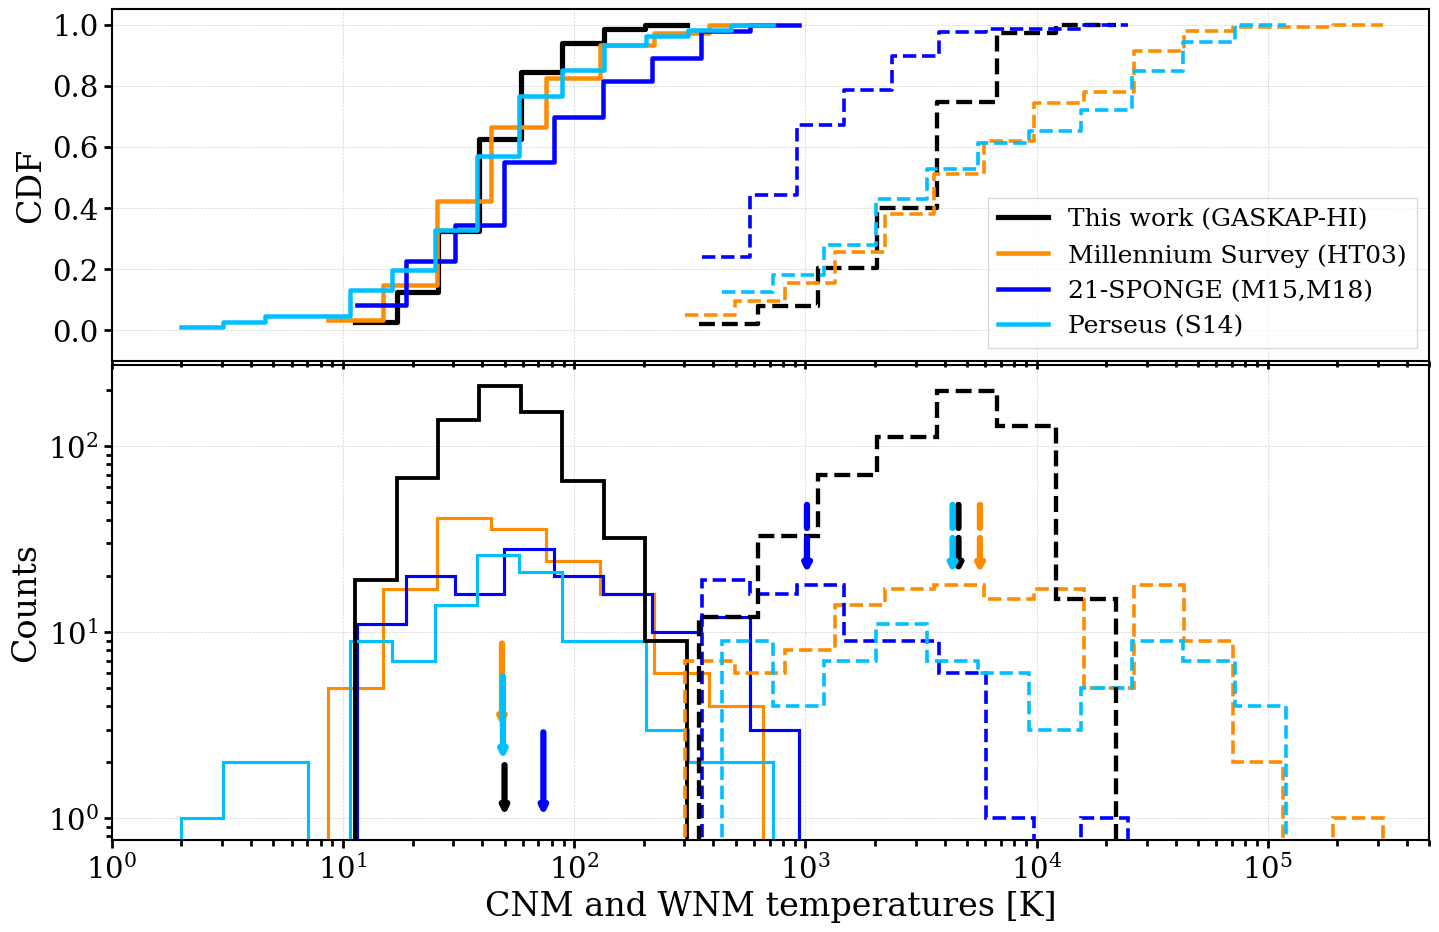

In [313]:
import matplotlib.gridspec as gridspec
mpl.rcParams['axes.linewidth'] = 1.5

lw = 2.25
binx = [10, 9, 15, 10, 5, 3]

linesty = '-' 
colors = ['b', 'darkorange', 'deepskyblue', 'gray', 'black', 'skyblue']
survey_labels = ['21-SPONGE (M15,M18)', 'Millennium Survey (HT03)', 'Perseus (S14)', 'GMRT04', 'GNOMES', 'MACH']


xylabel = 24
xytlabel = 21


# Figure
fig = plt.figure(figsize=(17,11))
gs = gridspec.GridSpec(7, 10)
ax = plt.subplot(gs[3:7, 0:10])
ax_cdf = plt.subplot(gs[0:3, 0:10],sharex=ax)

# ax
ploti, = ax.plot([], [], 'k-', lw=lw+1.5, label='This work (GASKAP-HI)')
ploti.set_visible(True)

mil_cnts, mil_bins, _ = ax.hist(mil_cpn_ts, bins = 10**np.linspace(np.log10(np.min(mil_cpn_ts)), np.log10(np.max(mil_cpn_ts)), binx[1]), color=colors[1],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[1], ls=linesty, lw=lw, label=survey_labels[1])
ploti.set_visible(True)

spo_cnts, spo_bins, _ = ax.hist(spo_cpn_ts, bins = 10**np.linspace(np.log10(np.min(spo_cpn_ts)), np.log10(np.max(spo_cpn_ts)), binx[0]), color=colors[0],
         density=False,  histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[0], ls=linesty, lw=lw, label=survey_labels[0])
ploti.set_visible(True)


per_cnts, per_bins, _ = ax.hist(per_cpn_ts, bins = 10**np.linspace(np.log10(np.min(per_cpn_ts)), np.log10(np.max(per_cpn_ts)), binx[2]), color=colors[2],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[2], ls=linesty, lw=lw, label=survey_labels[2])
ploti.set_visible(True)

cnts, bins, _ = ax.hist(tscnm, bins = 10**np.linspace(np.log10(np.min(tscnm)), np.log10(np.max(tscnm)), 9),
         density=False, color='k',
         alpha=1., ls='-', lw=lw+0.5, histtype='step',
         label='')

## Arrows for medians
med_ts = np.median(tscnm)
spo_med_ts = np.median(spo_cpn_ts)
mil_med_ts = np.median(mil_cpn_ts)
per_med_ts = np.median(per_cpn_ts)
ax.annotate('', xy=(med_ts, 1.), xycoords='data', xytext=(med_ts, 2.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='k', lw=4.5, ls='-'))
ax.annotate('', xy=(spo_med_ts, 1.), xycoords='data', xytext=(spo_med_ts, 3.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[0], lw=4.5, ls='-'))
ax.annotate('', xy=(mil_med_ts, 3.), xycoords='data', xytext=(mil_med_ts, 9.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[1], lw=4.5, ls='-'))
ax.annotate('', xy=(per_med_ts, 2.), xycoords='data', xytext=(per_med_ts, 6.), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[2], lw=4.5, ls='-'))








# Top
cdf = np.cumsum(cnts)/np.sum(cnts)
ax_cdf.set_ylabel('CDF', fontsize=xylabel)

ax_cdf.plot(
    np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2],
    np.vstack((cdf, cdf)).T.flatten(),
    color='k', ls='-', lw=lw+1.5,
    alpha=0.99, label='This work (GASKAP-HI)',
)

cdf3 = np.cumsum(mil_cnts)/np.sum(mil_cnts)

ax_cdf.plot(
    np.vstack((mil_bins, np.roll(mil_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[1], ls=linesty, lw=lw+1,
    alpha=0.99, label=survey_labels[1]
)


cdf3 = np.cumsum(spo_cnts)/np.sum(spo_cnts)

ax_cdf.plot(
    np.vstack((spo_bins, np.roll(spo_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[0], ls=linesty, lw=lw+1,
    alpha=0.99, label=survey_labels[0]
)

cdf3 = np.cumsum(per_cnts)/np.sum(per_cnts)

ax_cdf.plot(
    np.vstack((per_bins, np.roll(per_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[2], ls=linesty, lw=lw+1,
    alpha=0.99, label=survey_labels[2]
)




########################## Tk,max ##################
lw = 2.6
binx = [10, 15, 12, 10, 5, 3]
linesty = '--' 

mil_cnts, mil_bins, _ = ax.hist(mil_cpn_td, bins = 10**np.linspace(np.log10(np.min(mil_cpn_td)), np.log10(np.max(mil_cpn_td+100.)), binx[1]), color=colors[1],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[1], ls=linesty, lw=lw, label=survey_labels[1])
ploti.set_visible(True)

spo_cnts, spo_bins, _ = ax.hist(spo_cpn_td, bins = 10**np.linspace(np.log10(np.min(spo_cpn_td)), np.log10(np.max(spo_cpn_td+100.)), binx[0]), color=colors[0],
         density=False,  histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[0], ls=linesty, lw=lw, label=survey_labels[0])
ploti.set_visible(True)


per_cnts, per_bins, _ = ax.hist(per_cpn_td, bins = 10**np.linspace(np.log10(np.min(per_cpn_td)), np.log10(np.max(per_cpn_td+100.)), binx[2]), color=colors[2],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[2], ls=linesty, lw=lw, label=survey_labels[2])
ploti.set_visible(True)

cnts, bins, _ = ax.hist(td, bins = 10**np.linspace(np.log10(np.min(td)), np.log10(np.max(td+100.)), 8),
         density=False, color='k',
         alpha=1., ls='--', lw=lw+0.5, histtype='step',
         label='')





## Arrows for medians
u0 = 20.
u1 = 50.
med_td = np.median(td)
spo_med_td = np.median(spo_cpn_td)
mil_med_td = np.median(mil_cpn_td)
per_med_td = np.median(per_cpn_td)
print('GASKAP: ', np.min(td), np.mean(td), np.mean(td), np.max(td))
print('SPO: ', np.min(spo_cpn_td), np.mean(spo_cpn_td), np.median(spo_cpn_td), np.max(spo_cpn_td))
print('MIL: ', np.min(mil_cpn_td), np.mean(mil_cpn_td), np.median(mil_cpn_td), np.max(mil_cpn_td))
print('PER: ', np.min(per_cpn_td), np.mean(per_cpn_td), np.median(per_cpn_td), np.max(per_cpn_td))
ax.annotate('', xy=(med_td, u0), xycoords='data', xytext=(med_td, u1), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='k', lw=4.5, ls='--'))
ax.annotate('', xy=(spo_med_td, u0), xycoords='data', xytext=(spo_med_td, u1), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[0], lw=4.5, ls='--'))
ax.annotate('', xy=(mil_med_td, u0), xycoords='data', xytext=(mil_med_td, u1), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[1], lw=4.5, ls='--'))
ax.annotate('', xy=(per_med_td, u0), xycoords='data', xytext=(per_med_td, u1), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color=colors[2], lw=4.5, ls='--'))








# BIGHICAT
ax.set_xlabel(r'CNM and WNM temperatures [K]', fontsize=xylabel) # , T$_\mathrm{s}$ 
ax.set_ylabel('Counts', fontsize=xylabel)

ax.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax.tick_params(axis='y', labelsize=xytlabel)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

ax.set_xlim(1, 5.e5)
ax.set_yscale('log')
ax.set_xscale('log')



# Top
cdf = np.cumsum(cnts)/np.sum(cnts)
ax_cdf.set_ylabel('CDF', fontsize=xylabel)

ax_cdf.plot(
    np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2],
    np.vstack((cdf, cdf)).T.flatten(),
    color='k', ls='--', lw=lw+0.5,
    alpha=0.99, label='',
)

cdf3 = np.cumsum(mil_cnts)/np.sum(mil_cnts)

ax_cdf.plot(
    np.vstack((mil_bins, np.roll(mil_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[1], ls=linesty, lw=lw,
    alpha=0.99, label=''
)


cdf3 = np.cumsum(spo_cnts)/np.sum(spo_cnts)

ax_cdf.plot(
    np.vstack((spo_bins, np.roll(spo_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[0], ls=linesty, lw=lw,
    alpha=0.99, label=''
)

cdf3 = np.cumsum(per_cnts)/np.sum(per_cnts)

ax_cdf.plot(
    np.vstack((per_bins, np.roll(per_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[2], ls=linesty, lw=lw,
    alpha=0.99, label=''
)



ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax_cdf.tick_params(axis='y', labelsize=xytlabel)
ax_cdf.tick_params(which='both', width=2)
ax_cdf.tick_params(which='major', length=6)
ax_cdf.tick_params(which='minor', length=4)

ax_cdf.set_ylim(-0.1,1.05)

ax_cdf.tick_params('y', colors='k')
ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
plt.setp(ax_cdf.get_xticklabels(), visible=False)

ax_cdf.legend(loc='lower right', fancybox=False, framealpha=0.75, labelcolor='k', fontsize=18)


# Adjust the position of the second panel
pos2 = ax.get_position()
ax.set_position([pos2.x0, pos2.y0 + 0.015, pos2.width, pos2.height])

plt.show()

In [315]:
# Statistical Tests

# Kolmogorov-Smirnov Test
ks_test_12 = ks_2samp(td, mil_cpn_td)
ks_test_13 = ks_2samp(td, spo_cpn_td)
ks_test_14 = ks_2samp(td, per_cpn_td)
ks_test_23 = ks_2samp(mil_cpn_td, spo_cpn_td)
ks_test_24 = ks_2samp(mil_cpn_td, per_cpn_td)
ks_test_34 = ks_2samp(spo_cpn_td, per_cpn_td)

print(f'KS Test GASKAP vs HT03: {ks_test_12}')
print(f'KS Test GASKAP vs SPO: {ks_test_13}')
print(f'KS Test GASKAP vs Perseus: {ks_test_14}')
print(f'KS Test HT03 vs SPO: {ks_test_23}')
print(f'KS Test HT03 vs Perseus: {ks_test_24}')
print(f'KS Test SPO vs Perseus: {ks_test_34}')

# ANOVA
anova_test = f_oneway(td, mil_cpn_td, spo_cpn_td, per_cpn_td)
print(f'ANOVA Test: {anova_test}')

# Kruskal-Wallis Test
kruskal_test = kruskal(td, mil_cpn_td, spo_cpn_td, per_cpn_td)
print(f'Kruskal-Wallis Test: {kruskal_test}')

KS Test GASKAP vs HT03: KstestResult(statistic=0.3175161101347393, pvalue=1.9792541543974835e-10, statistic_location=12989.639708000022, statistic_sign=1)
KS Test GASKAP vs SPO: KstestResult(statistic=0.5683077128428734, pvalue=1.731816948699728e-21, statistic_location=2607.36344037785, statistic_sign=-1)
KS Test GASKAP vs Perseus: KstestResult(statistic=0.35719960517129307, pvalue=7.032916916077589e-08, statistic_location=12122.999810033652, statistic_sign=1)
KS Test HT03 vs SPO: KstestResult(statistic=0.5455879655109154, pvalue=2.7908835248736735e-14, statistic_location=2607.36344037785, statistic_sign=-1)
KS Test HT03 vs Perseus: KstestResult(statistic=0.14353782013103036, pvalue=0.24840414898504942, statistic_location=31466.237095999997, statistic_sign=1)
KS Test SPO vs Perseus: KstestResult(statistic=0.4770244494537888, pvalue=2.294620891988155e-08, statistic_location=1516.5413703873126, statistic_sign=1)
ANOVA Test: F_onewayResult(statistic=37.29059361899986, pvalue=1.18609055833